Preparation and analysis of data: Tang et al, AJP, Image-based machine learning algorithms for disease characterization in the human type 1 diabetes pancreas

### Dependencies

This notebook uses SAS and R.  R is free, SAS is not.  You must have a SAS license to run SAS or use SAS University Edition.  See our github page from a previous publication that describes the installation process of SAS University Edition. 

In addition, you need to install the SAS kernal for jupyter notebook, available here: https://github.com/sassoftware/sas_kernel

All file paths in this notebook will need to be revised to the destination you choose to place this notebook and all the datafiles.

r packages and set the working directory
consider use of packrat to save R packages and versions locally with each project (improve reproducibility)

In [87]:
#install.packages(c("ggthemes", "ggpubr"))

In [88]:
#.libPaths()

In [89]:
#to see color code for brewer palette for donorgroups
#brewer.pal(8, "Dark2")

#to see color code for brewer palette for pancreas head, body, tail
#brewer.pal(11, "BrBG")

The below libraries are needed.  Issues related to library installation may be related to set up and machine, therefore not addressed here.  Make sure all packages are installed prior to loading, i.e. install.packages 

In [90]:
library(ggplot2)
library(beeswarm)
library(ggbeeswarm)
library(rio)
library(tidyverse)
library(magrittr)
library(ggthemes)
library(plyr)
library(dplyr)
library(readr)
library(cowplot)
library(ggpubr)
library(RColorBrewer)
library(ggsignif)
library(shadowtext)


#for use when connected to network
#setwd('F://Manuscripts//nPOD_requests//pancreas_size//data')

#for use when off network
setwd('C://Users//jkaddis//Desktop//pancreas_size//data')

setting location of data files for use in SAS

In [91]:
%let location= C:\Users\jkaddis\Desktop\pancreas_size;

*%let location= F:\Manuscripts\nPOD_requests\pancreas_size;

### basic data prep work

Medical and clinical datasets downloaded from datashare. Latest download of data on July 7, 2019.  

In [92]:
PROC import datafile = "&location\Data\Demographics_2019-07-09_17-12-02.xlsx" 
     out      = demographics 
     dbms = xlsx replace;
     getnames=yes;
RUN;

PROC import datafile = "&location\Data\Pancreas Weights_2019-07-09_17-12-46.xlsx" 
     out      = panc_weights 
     dbms = xlsx replace;
     getnames=yes;
RUN;

PROC import datafile = "&location\Data\Duration of Donor Hospitalization_2019-07-09_17-13-07.xlsx" 
     out      = hosp_time 
     dbms = xlsx replace;
     getnames=yes;
RUN;

PROC import datafile = "&location\Data\Organ Transportation Time_2019-07-09_17-13-20.xlsx" 
     out      = transport_time 
     dbms = xlsx replace;
     getnames=yes;
RUN;

PROC import datafile = "&location\Data\RIA_AutoAb_Results_2019-07-10_05-18-45.xlsx" 
     out      = antibodies 
     dbms = xlsx replace;
     getnames=yes;
RUN;


PROC import datafile = "&location\Data\Hi Res HLA Post Receipt of Organ_2019-07-29_15-25-54.xlsx" 
     out      = HLA 
     dbms = xlsx replace;
     getnames=yes;
RUN;

DATA HLA;
    set HLA;
    rename 'nPOD CaseID'n=nPODCaseID;
RUN;


The diabetes dataset has text fields with line breaks, which corrupts the file import. Below code solves that problem and was adpoted from http://support.sas.com/kb/26/065.html

In [93]:
/************************** CAUTION ***************************/
/*                                                            */
/* This program UPDATES IN PLACE, create a backup copy before */
/* running.                                                   */
/*                                                            */
/************************** CAUTION ***************************/
                                                           
/* Replace carriage return and linefeed characters inside     */
/* double quotes with a specified character.  This sample     */
/* uses '@' and '$', but any character can be used, including */
/* spaces.  CR/LFs not in double quotes will not be replaced. */


%let repA='@';                    /* replacement character LF */
%let repD='$';                    /* replacement character CR */

                             
%let dsnnme="&location\Data\Diabetes Information_2019-07-09_17-13-50.csv";      /* use full path of CSV file */

data _null_;
  /* RECFM=N reads the file in binary format. The file consists    */
  /* of a stream of bytes with no record boundaries.  SHAREBUFFERS */
  /* specifies that the FILE statement and the INFILE statement    */
  /* share the same buffer.                                        */
  infile &dsnnme recfm=n sharebuffers;
  file &dsnnme recfm=n;

  /* OPEN is a flag variable used to determine if the CR/LF is within */
  /* double quotes or not.  Retain this value.                        */
  retain open 0;

  input a $char1.;
  /* If the character is a double quote, set OPEN to its opposite value. */
  if a = '"' then open = ^(open);

  /* If the CR or LF is after an open double quote, replace the byte with */
  /* the appropriate value.                                               */
  if open then do;
    if a = '0D'x then put &repD;
    else if a = '0A'x then put &repA;
  end;
run;

PROC import datafile = "&location\Data\Diabetes Information_2019-07-09_17-13-50.csv" 
     out      = diabetes 
     dbms = csv replace;
     getnames=yes;
     guessingrows=1000;
RUN;

Merge all datasets

In [94]:
/*due to jupyter notebook magics, this line of code is needed when creating a new macro.  As long as there is a 
line before the %macro, the cell will be interpretted correctly.  This is not needed if running SAS natively*/

%macro sort (D);
PROC sort data=&D;
by nPODCaseID;
RUN;
%mend sort;

%sort (demographics); run;
%sort (diabetes); run;
%sort (panc_weights); run;
%sort (hosp_time); run;
%sort (transport_time); run;
%sort (antibodies); run;
%sort (HLA); run;

DATA clinical;
    merge demographics diabetes panc_weights hosp_time transport_time antibodies HLA;
    by nPODCaseID;
RUN;

/*inspect dataset outside of notebook*/
PROC export data=clinical 
     outfile="&location\Data\clinical.csv" 
     dbms=csv
     replace;
run; 

clean up clinical dataset for analysis

In [95]:
DATA clinical1;
    set clinical;
    
    oppc_ethnicity1=oppc_Ethnicity;
    if oppc_Ethnicity="American Indian/Alaska Native" then oppc_ethnicity1="Other";
    if oppc_Ethnicity="Asian" then oppc_ethnicity1="Other";
    if oppc_Ethnicity="Multiracial" then oppc_ethnicity1="Other";
    
    *donortype1=compress(donortype,'','s');
    donortype1=DonorType;
    if DonorType1="Cystic fibrosis" then donortype1="Other";
    if DonorType1="Gestational diabetes" then donortype1="Other";
    if DonorType1="Pending" then donortype1="Other";
    if DonorType1="Pregnancy" then donortype1="Other";
    
    cod4group=99;
    if cod_final="" then cod4group='.';
    IF cod_final="ANOXIA" then cod4group=1; /*anoxia*/
    IF cod_final="CEREBROVASCULAR/STROKE" then cod4group=2; /*cerebrovascular/stroke*/
    IF cod_final="Other: Cardiovascular" then cod4group=2; /*cerebrovascular/stroke*/
    IF cod_final="Cerebral edema" then cod4group=2; /*cerebrovascular/stroke*/
    IF cod_final="HEAD TRAUMA" then cod4group=3; /*head trauma*/
    if cod_final="Cystic Fibrosis" then cod4group=4; /*other*/
    if cod_final="DKA" then cod4group=4; /*other*/
    if cod_final="DKA, cerebral edema" then cod4group=4; /*other*/
    if cod_final="Cystic Fibrosis" then cod4group=4; /*other*/
    if cod_final="Cystic Fibrosis" then cod4group=4; /*other*/
    if cod_final="Cystic Fibrosis" then cod4group=4; /*other*/
    if cod_final="Infectious Disease - Bacterial Meningitis" then cod4group=4; /*other*/
    if cod_final="Meningitis" then cod4group=4; /*other*/
    if cod_final="Perinatal Condition/Birth Defect" then cod4group=4; /*other*/
    if cod_final="Respiratory Distress/Failure" then cod4group=4; /*other*/
    if cod_final="Spinal Cord Injury" then cod4group=4; /*other*/
    
    oppc_c_peptideR1=.;
    if oppc_c_peptideR="Less than .05" then oppc_c_peptideR1=0.05;
    if oppc_c_peptideR="Less than .02" then oppc_c_peptideR1=0.02;
    if oppc_c_peptideR="Less than 0.02" then oppc_c_peptideR1=0.02;
    if (oppc_c_peptideR^="Less than .05" and oppc_c_peptideR^="Less than .02" and oppc_c_peptideR^="Less than 0.02") then oppc_c_peptideR1=oppc_c_peptideR*1;
    
    total_positive_autoab_count1=total_positive_autoab_count;
    if mIAA_Result="Positive" and donortype="T1D" then total_positive_autoab_count1=total_positive_autoab_count-1;
    if mIAA_Result="Positive" and donortype="T1D Medalist" then total_positive_autoab_count1=total_positive_autoab_count-1;
    
    
    /*need to convert hba1c at marthas request and present 2 different ways, based on equation found at http://www.ngsp.org/convert1.asp*/

    oppc_hba1cR1=.;
    oppc_hba1cR1=(oppc_hba1cR-2.152)/(0.09148);
    
    
    
        dr4dq0302=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr4dq0302=0;
    if 
    (index(DRB1_1, "04:")> 0 OR index(DRB1_1, "040")> 0 OR index(DRB1_1, "041")> 0 OR 
    index(DRB1_2, "04:")> 0 OR index(DRB1_2, "040")> 0 OR index(DRB1_2, "041")> 0) 
    AND
    (INDEX(DQB1_1, "0302")>0 OR INDEX(DQB1_1, "03:02") > 0 OR INDEX(DQB1_1, "03:02/3") > 0 OR 
     INDEX(DQB1_2, "0302")>0 OR INDEX(DQB1_2, "03:02") > 0 OR INDEX(DQB1_2, "03:02/3") > 0)
    then dr4dq0302=1;

    dr0301dq0201=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr0301dq0201=0;
    if 
    (index(DRB1_1, "03:01")> 0 OR index(DRB1_1, "03:01/5")> 0 OR index(DRB1_1, "0301")> 0 OR  
     index(DRB1_2, "03:01")> 0 OR index(DRB1_2, "03:01/5")> 0 OR index(DRB1_2, "0301")> 0)   
    AND 
    (INDEX(DQB1_1, "02:01")>0 OR INDEX(DQB1_1, "0201") > 0 OR
     INDEX(DQB1_2, "02:01")>0 OR INDEX(DQB1_2, "0201") > 0)
    then dr0301dq0201=1;


    dr4dq0302_only=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr4dq0302_only=0;
    if dr4dq0302=1 and dr0301dq0201=0 then dr4dq0302_only=1;

    dr0301dq0201_only=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr0301dq0201_only=0;
    if dr4dq0302=0 and dr0301dq0201=1 then dr0301dq0201_only=1;

    dr4ordr0301=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr4ordr0301=0;
    dr4ordr0301=dr4dq0302_only+dr0301dq0201_only;

    dr4anddr0301=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr4anddr0301=0;
    if (dr4dq0302=1) and (dr0301dq0201=1) then dr4anddr0301=1;

    dr1501dq0602=.;
    if drb1_1^="" and drb1_2^="" and dqb1_1^="" and dqb1_2^="" then dr1501dq0602=0;
    if 
    (index(DRB1_1, "15:01")> 0 OR index(DRB1_1, "1501")> 0 OR index(DRB1_1, "15:01/5")> 0 OR 
     index(DRB1_2, "15:01")> 0 OR index(DRB1_2, "1501")> 0 OR index(DRB1_2, "15:01/5")> 0)
    AND
    (INDEX(DQB1_1, "0302")>0 OR INDEX(DQB1_1, "06:02") > 0 OR INDEX(DQB1_1, "0602") > 0 OR INDEX(DQB1_1, "06:02/4") > 0 OR
     INDEX(DQB1_2, "0302")>0 OR INDEX(DQB1_2, "06:02") > 0 OR INDEX(DQB1_2, "0602") > 0 OR INDEX(DQB1_2, "06:02/4") > 0) 
    then dr1501dq0602=1;
    
    /*add relative pancreas weight*/
    if pancreas_received_intact="FALSE" then relative=.;
    if whole_pancreas_g=. then relative=.;
    if weight_g=. then relative=.;
    weight_g=oppc_weightR*1000;
    relative=whole_pancreas_g/weight_g*100;
    

RUN;


inspect merged and cleaned file

In [96]:
PROC export data=clinical1 
     outfile="&location\Data\clinical.csv" 
     dbms=csv
     replace;
run; 

Import study data file.  There are two workbooks, split each into a dataset.

In [97]:
PROC import out = cell datafile= 
            "&location\data\Data for John Kaddis-updated 0618.xls"
     dbms =  xls  replace;
     startrow=2;
     namerow=1;
     getnames=yes;
     mixed=yes;
     guessingrows=1000;
     sheet="Area and Cell Analysis";
RUN;


PROC import out = duct datafile= 
            "&location\data\Data for John Kaddis-updated 0618.xls"
     dbms =  xls  replace;
     startrow=2;
     namerow=1;
     getnames=yes;
     mixed=yes;
     guessingrows=1000;
     sheet="Main Duct Size";
RUN;

obtain caseIDs used in both studies

In [98]:
PROC sort data=cell nodupkey out=cell_ids;
by 'Case no.'n;
run;

DATA cell_ids (keep=nPODCaseID);
    set cell_ids;
    nPODCaseID=put ('Case no.'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;


PROC sort data=duct nodupkey out=duct_ids;
by 'Case no.'n;
run;

DATA duct_ids (keep=nPODCaseID);
    set duct_ids;
    nPODCaseID=put ('Case no.'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;

clean both study files prior to use

In [99]:
DATA duct1 (drop= 'Case no.'n a group age HbA1c BMI 'Body weight(kg)'n 'Whole Pancreas (g)'n 'Panhead (g)'n 'Panbody (g)'n 'Pantail (g)'n);
    set duct;
    nPODCaseID=put ('Case no.'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;

DATA cell1 (drop= 'Case no.'n a group age 'Body weight(kg)'n 'Whole Pancreas (g)'n 'Panhead (g)'n 'Panbody (g)'n 'Pantail (g)'n);
    set cell;
    nPODCaseID=put ('Case no.'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;

import matching code

In [100]:
PROC import out = cell_match datafile= 
            "&location\data\match_pairs_cells_study.xlsx"
     dbms = xlsx replace;
     getnames=yes;
RUN;

DATA cell_match (keep=nPODCaseID matching_cell);
    set cell_match;
    nPODCaseID=put ('CaseID'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;
PROC sort data=cell_match;
    by nPODCaseID;
RUN;


PROC import out = duct_match datafile= 
            "&location\data\match_pairs_duct_study.xlsx"
     dbms = xlsx replace;
     getnames=yes;
RUN;


DATA duct_match (keep=nPODCaseID matching_duct);
    set duct_match;
    nPODCaseID=put ('CaseID'n, 10. -L); /*left align since num to char conversion right aligns*/
RUN;
PROC sort data=duct_match;
    by nPODCaseID;
RUN;

In [101]:
PROC format;
     value $order
     'No diabetes' = '1_No diabetes'
     'Autoab Pos' = '2_Autoab Pos'
     'T1D' = '3_T1D'  

### supplemental tables 1-3

basic demographics profile of donors for each study

data prep for cell study

In [102]:
/*step1*/

DATA cell_demo;
    merge cell_ids (in=a) clinical1 cell_match ;
    by nPODCaseID;
    if a;
run;

proc export data=cell_demo
     outfile="&location\Data\cell_demo.csv" 
     dbms=csv
     replace;
run; 


/*step 2*/
DATA cell_demo_limited (keep=nPODCaseID Donortype);
    set cell_demo;
RUN;

data cell2;
    merge cell1 (in=a) cell_demo_limited;
    by nPODCaseID;
    if a;
RUN;

DATA cell3;
    set cell2;
    percent_endocrine_area=(('Islet Area (mm²)'n)/('Total Tissue  Area (mm²)'n))*100;
    percent_acinar_area=(('Acinar Area (mm²)'n)/('Total Tissue  Area (mm²)'n))*100;
    percent_remaining_area=(('Duct and other Area (mm²)'n)/('Total Tissue  Area (mm²)'n))*100;
    endocrine_density=('Total islet cell number'n)/('Islet Area (mm²)'n);
    acinar_density=('Total acinar cell numbers'n)/('Acinar Area (mm²)'n);
    endocrine_cell_size='islets: Avg Cell Area (cell size'n;
    acinar_cell_size='acinar: Avg Cell Area (cell size'n;
    donorgroup=donortype;
    if INS=0 and donortype="T1D" then donorgroup="Ins. neg. T1D";
    if INS=1 and donortype="T1D" then donorgroup="Ins. pos. T1D";
RUN;

/*step 3 - figure prep*/


/*althgouh cell size data is quantatative, given inprecise nature of numbers, bin into groups instead of using actual values*/

PROC rank data=cell3 out=cell3 groups=20;
    var endocrine_cell_size; ranks endocrine_cell_size_scale;
RUN;

PROC rank data=cell3 out=cell3 groups=20;
    var acinar_cell_size; ranks acinar_cell_size_scale;
RUN;

/*ranking function above placed data on scale from 0-4, but desired a scale of 1-5 instead*/
DATA cell3;
    set cell3;
    endocrine_cell_size_scale1=endocrine_cell_size_scale+1;
    acinar_cell_size_scale1=acinar_cell_size_scale+1;
RUN;

/*combine data from head, body, and tail into one representative number*/
PROC sort data=cell3;
    by npodcaseid;
run;

proc sql;
create table cell3_combined as
select *, mean(percent_endocrine_area) as mean_percent_endocrine_area,
mean(percent_acinar_area) as mean_percent_acinar_area,
mean(percent_remaining_area) as mean_percent_remaining_area,
mean(endocrine_density) as mean_endocrine_density,
mean(acinar_density) as mean_acinar_density,
mean(endocrine_cell_size) as mean_endocrine_cell_size,
mean(endocrine_cell_size_scale1) as mean_endocrine_cell_size_scale1,
mean(acinar_cell_size_scale1) as mean_acinar_cell_size_scale1
from cell3
group by npodcaseid;
quit;

/*summarize data by donorgroup*/
PROC sort data=cell3_combined;
    by donorgroup;
RUN;

proc sql;
create table cell3_combined_donorgroup as
select *, mean(mean_percent_endocrine_area) as group_percent_endocrine_area,
mean(mean_percent_acinar_area) as group_percent_acinar_area,
mean(mean_percent_remaining_area) as group_percent_remaining_area,
mean(mean_endocrine_density) as group_endocrine_density,
mean(mean_acinar_density) as group_acinar_density,
mean(mean_endocrine_cell_size) as group_endocrine_cell_size,
mean(mean_endocrine_cell_size_scale1) as group_endocrine_cell_size_scale1,
mean(mean_acinar_cell_size_scale1) as group_acinar_cell_size_scale1

from cell3_combined
group by donorgroup;
quit;

/*inspect data*/
proc export data=cell3_combined_donorgroup
     outfile="&location\Data\cell3.csv" 
     dbms=csv
     replace;
run; 


/*prepare data for lollipop chart*/
PROC sort data=cell3_combined_donorgroup out=lollipop NODUPKEY;
    by donorgroup group_percent_endocrine_area group_percent_acinar_area group_percent_remaining_area group_endocrine_density group_acinar_density;
RUN;

proc export data=lollipop
     outfile="&location\Data\cell3_lollipop.csv" 
     dbms=csv
     replace;
run; 




supplemental table 3: cell study


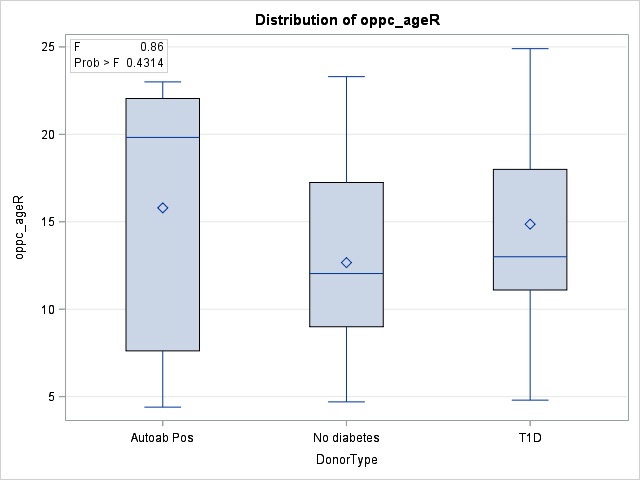
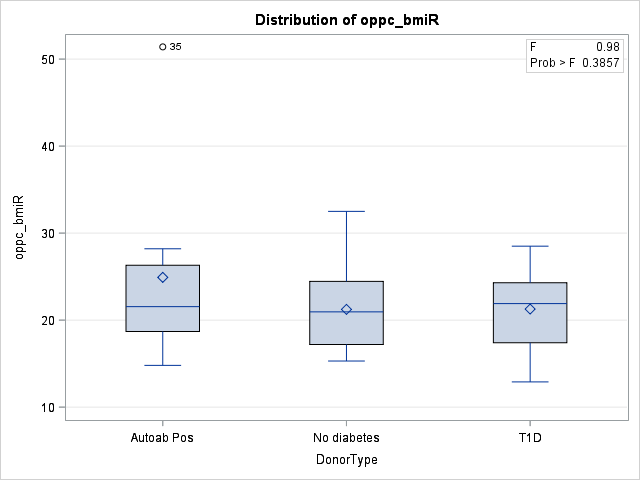
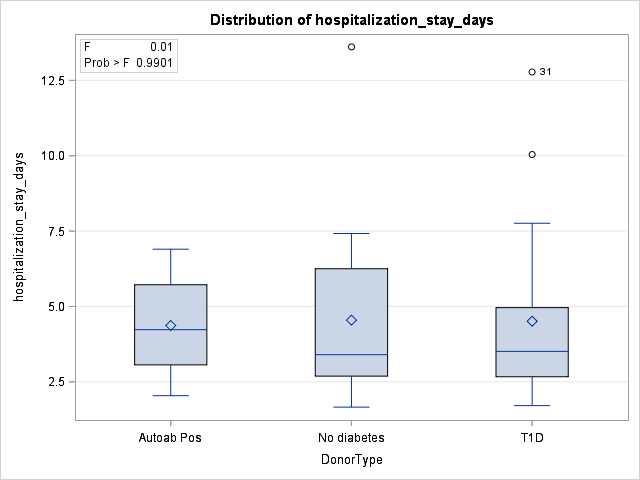
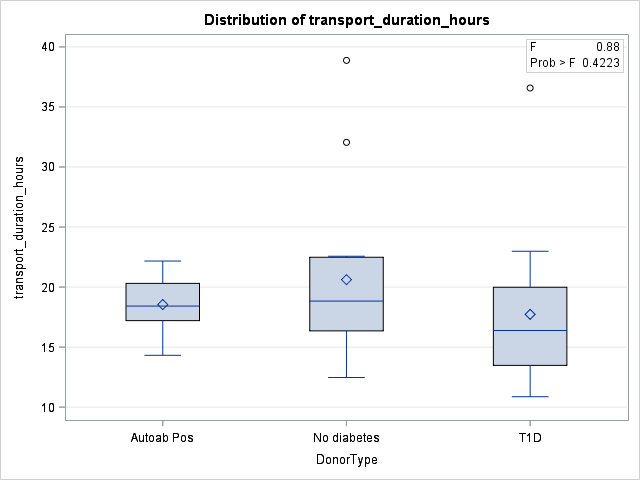
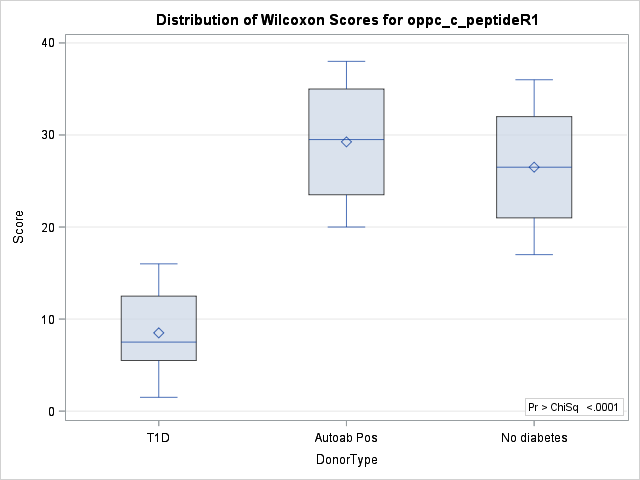
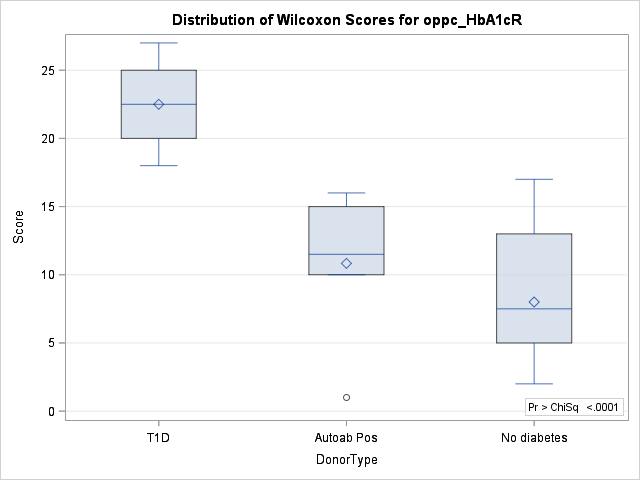

In [103]:
PROC univariate data=cell_demo;
    var oppc_ageR oppc_bmiR  oppc_c_peptideR1 hospitalization_stay_days transport_duration_hours oppc_hba1cr;
RUN;

/*diabetes_duration_yrs not tested*/

/*continuous parametric: ANOVA for multi-group comparisons*/

%macro anova (X); 
proc anova data = cell_demo;
      class DonorType;
      model &X = DonorType;
   run;
%mend anova;

%anova (oppc_ageR);
%anova (oppc_bmiR);
%anova (hospitalization_stay_days);
%anova (transport_duration_hours);
run;

/*continuous non-parametric: wilcoxan rank sum*/

%macro npar1way (X);
proc npar1way data = cell_demo wilcoxon;
  class DonorType;
  var &X;
%mend npar1way;

%npar1way (oppc_c_peptideR1);
%npar1way (oppc_hba1cr);   
run;



/*p-values were calculated for both 2- and multi-class categorical nominal data.  Fisher's exact test was used when values from 1 or more cells in a contingency table (2 x 2 or R x C) were less than 5.  Pearson's chi square was used where values in all cells exceeded 5. If values from 2 or more cells in any table were equal to 0, p-values were not generated.*/

%macro freq (X);
proc freq data=cell_demo;
tables &X*DonorType/measures chisq;
%mend freq;


%macro freq1 (X);
proc freq data=cell_demo;
tables &X*DonorType/measures fisher;
%mend freq1;

%freq1 (oppc_gender); RUN;
%freq1 (dr4dq0302_only);
%freq1 (dr0301dq0201_only);
%freq1 (dr4anddr0301);
%freq1 (dr1501dq0602);


/*oppc_ethnicity1 and cod4group &  total_positive_autoab_count1 not tested due to small smaple size, i.e. valves from 2 cells equaled 0*/


PROC freq data=cell_demo;
    tables donortype;
RUN;



/*data for tables*/

PROC sort data=cell_demo;
    by donortype;
RUN;

PROC means data=cell_demo n mean std;
    var oppc_ageR oppc_bmiR  transport_duration_hours diabetes_duration_yrs;
    by donortype;
RUN;

PROC means data=cell_demo n median min max;
    var oppc_c_peptideR1 hospitalization_stay_days oppc_hba1cR oppc_hba1cR1 ;
    by donortype;
RUN;

PROC freq data=cell_demo ORDER=FORMATTED;
     format donortype $order.;
    tables oppc_gender*donortype oppc_ethnicity1*donortype cod4group*donortype total_positive_autoab_count1*donortype;
RUN;

supplemental table 2: duct study


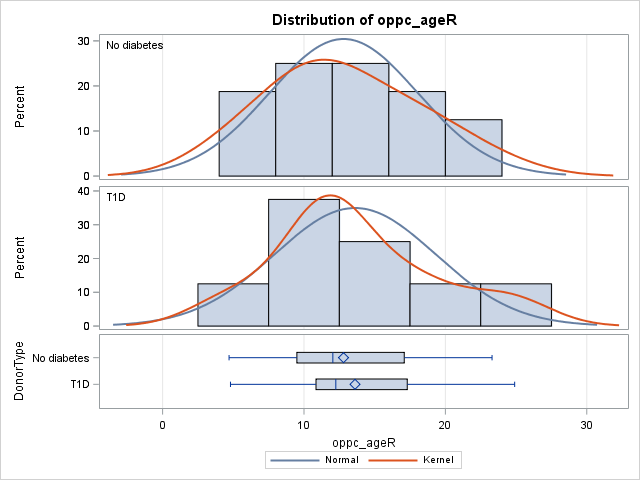
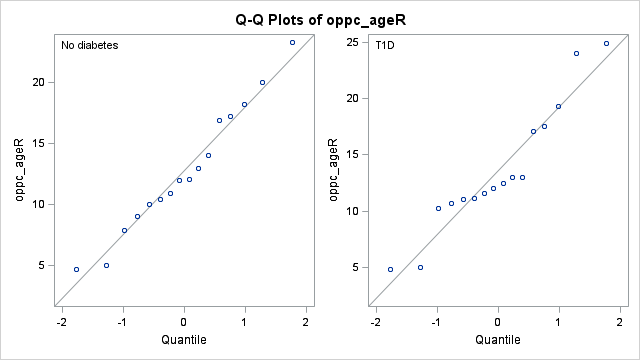
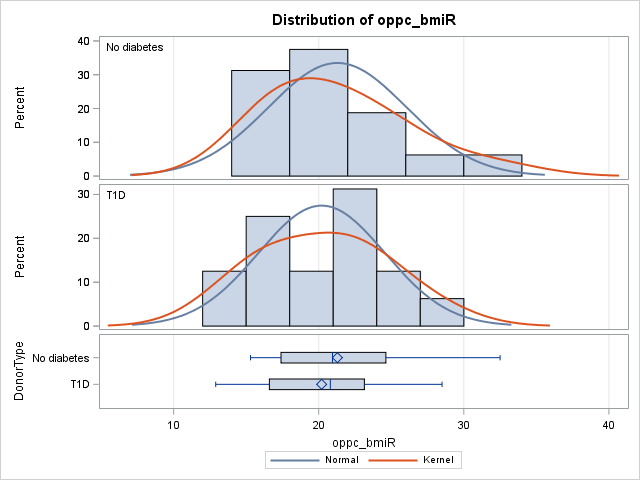
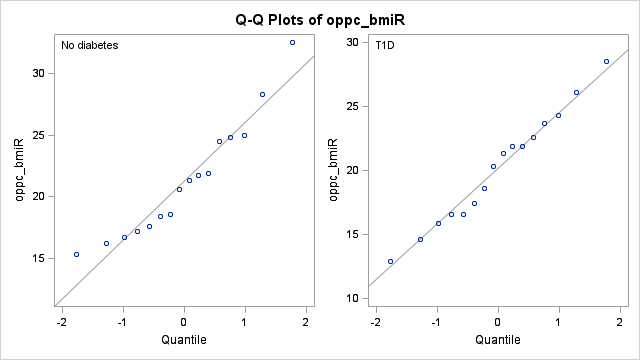
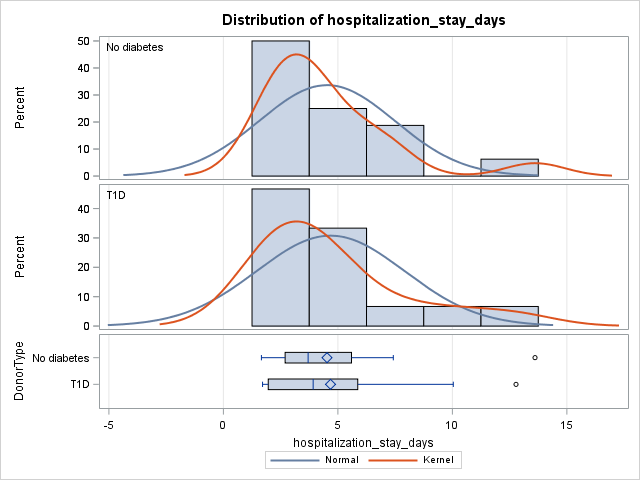
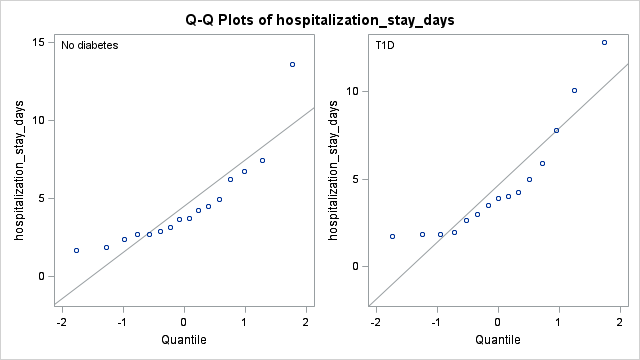
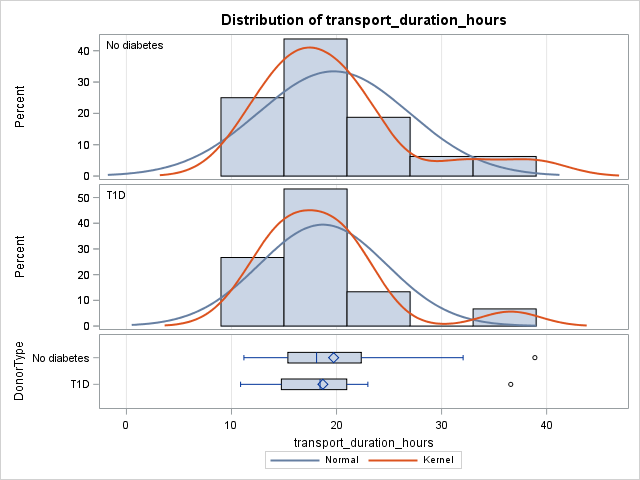
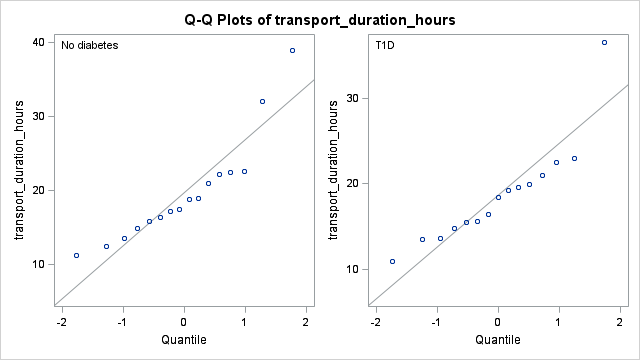
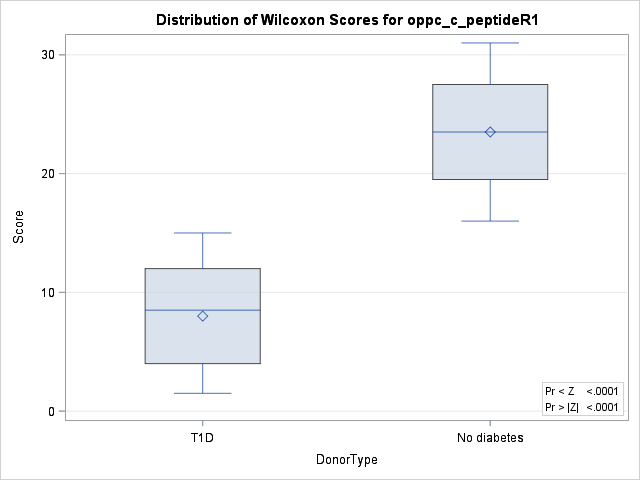
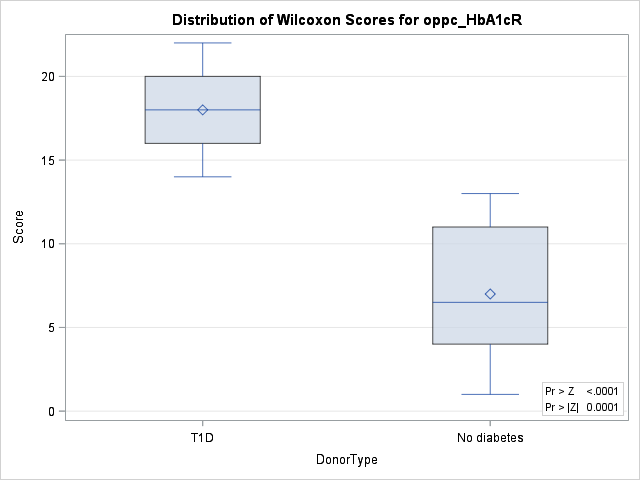

In [104]:
/*for duct study*/

DATA duct_demo;
    merge duct_ids (in=a) clinical1 duct_match;
    by nPODCaseID;
    if a;
run;

PROC univariate data=duct_demo;
    var oppc_ageR oppc_bmiR  oppc_c_peptideR1 hospitalization_stay_days transport_duration_hours oppc_hba1cr;
RUN;

proc export data=duct_demo
     outfile="&location\Data\duct_demo.csv" 
     dbms=csv
     replace;
run; 


/*diabetes_duration_yrs not tested*/

/*continuous parametric: 2 group t-test*/
%macro runttest (X);
PROC ttest data=duct_demo;
    class donortype;
    var &X;
RUN;
%mend runttest;

%runttest (oppc_ageR);
%runttest (oppc_bmiR);
%runttest (hospitalization_stay_days);
%runttest (transport_duration_hours);

/*continuous non-parametric: wilcoxon*/


%macro npar1way (X);
proc npar1way data = duct_demo wilcoxon;
  class DonorType;
  var &X;
%mend npar1way;

%npar1way (oppc_c_peptideR1);RUN;
%npar1way (oppc_hba1cr);RUN;


/*p-values were calculated for both 2- and multi-class categorical nominal data.  Fisher's exact test was used when values from 1 or more cells in a contingency table (2 x 2 or R x C) were less than 5.  Pearson's chi square was used where values in all cells exceeded 5. If values from 2 or more cells in any table were equal to 0, p-values were not generated.*/

%macro freq (X);
proc freq data=duct_demo;
tables &X*DonorType/measures chisq;
%mend freq;


%macro freq1 (X);
proc freq data=duct_demo;
tables &X*DonorType/measures fisher;
%mend freq1;

%freq (oppc_gender);RUN;
%freq1 (oppc_ethnicity1);RUN;
%freq1 (cod4group);RUN;
%freq1 (dr4dq0302_only);RUN;
%freq1 (dr0301dq0201_only);RUN;
%freq1 (dr4anddr0301);RUN;
%freq1 (dr1501dq0602);RUN;

PROC freq data=duct_demo;
    tables donortype;
RUN;


/*data for tables*/

PROC sort data=duct_demo;
    by donortype;
RUN;

PROC means data=duct_demo n mean std;
    var oppc_ageR oppc_bmiR  transport_duration_hours diabetes_duration_yrs;
    by donortype;
RUN;

PROC means data=duct_demo n median min max;
    var oppc_c_peptideR1 hospitalization_stay_days oppc_hba1cR oppc_hba1cR1 ;
    by donortype;
RUN;

PROC freq data=duct_demo ORDER=FORMATTED;
     format donortype $order.;
    tables oppc_gender*donortype oppc_ethnicity1*donortype cod4group*donortype total_positive_autoab_count1*donortype;
RUN;

supplemental table 1: overall numbers for both studies

In [105]:
PROC sort data=duct_demo;
    by nPODCaseID;
RUN;

PROC sort data=cell_demo;
    by nPODCaseID;
RUN;


DATA overall;
merge duct_demo cell_demo;
by nPODCaseID;
run;

PROC freq data=overall;
    tables donortype;
RUN;


/*bring in INS+ status from study for main demo table*/

DATA overall;
    set overall;
    donortype1=donortype;
    if nPODCaseID=6052 then donortype1="T1D INS+";
    if nPODCaseID=6195 then donortype1="T1D INS+";
    if nPODCaseID=6209 then donortype1="T1D INS+";
    if nPODCaseID=6228 then donortype1="T1D INS+";
    if nPODCaseID=6243 then donortype1="T1D INS+";
    if nPODCaseID=6247 then donortype1="T1D INS+";
    if nPODCaseID=6265 then donortype1="T1D INS+";
    if nPODCaseID=6362 then donortype1="T1D INS+";
    if nPODCaseID=6371 then donortype1="T1D INS+";
    if nPODCaseID=6380 then donortype1="T1D INS+";
    if nPODCaseID=6396 then donortype1="T1D INS+";
    if nPODCaseID=6472 then donortype1="T1D INS+";
    if nPODCaseID=6062 then donortype1="T1D INS-";
    if nPODCaseID=6064 then donortype1="T1D INS-";
    if nPODCaseID=6079 then donortype1="T1D INS-";
    if nPODCaseID=6087 then donortype1="T1D INS-";
    if nPODCaseID=6089 then donortype1="T1D INS-";
    if nPODCaseID=6237 then donortype1="T1D INS-";
    if nPODCaseID=6360 then donortype1="T1D INS-";
run;

PROC freq data=overall;
    tables donortype donortype1;
RUN;

proc export data=overall
     outfile="&location\Data\overall.csv" 
     dbms=csv
     replace;
run; 


PROC Sort data=overall;
 by donortype1;
RUN;


PROC univariate data=overall;
    var oppc_ageR oppc_bmiR  oppc_c_peptideR1 hospitalization_stay_days transport_duration_hours diabetes_duration_yrs oppc_hba1cR oppc_hba1cR1;
RUN;

PROC means data=overall n mean std;
    var oppc_ageR oppc_bmiR  transport_duration_hours diabetes_duration_yrs;
    by donortype1;
RUN;

PROC means data=overall n median min max;
    var oppc_c_peptideR1 hospitalization_stay_days oppc_hba1cR oppc_hba1cR1 ;
    by donortype1;
RUN;

PROC freq data=overall ORDER=FORMATTED;
     format donortype1 $order.;
    tables oppc_gender*donortype1 oppc_ethnicity1*donortype1 cod4group*donortype1 total_positive_autoab_count1*donortype1 dr4dq0302_only*donortype1 dr0301dq0201_only*donortype1 dr4anddr0301*donortype1 dr1501dq0602*donortype1;
RUN;



### supplemental figures 1-2

supplemental figure 2:pancreas weight differences

In [106]:
/*for supplemental figure 1 - analyze all nPOD data*/

DATA panc;
    set clinical1;
    if oppc_ageR<=1 then age_group=0;                     /*developmental and neonates*/
    if oppc_ageR>1 and oppc_ageR<=12 then age_group=1;   /*child*/
    if oppc_ageR>12 and oppc_ageR<=18 then age_group=2;  /*adolescent*/
    if oppc_ageR>18 then age_group=3;                   /*adult*/

    
    if donortype^="No diabetes" and donortype^="Autoab Pos" and donortype^="T1D" then delete;
    if donortype="No diabetes" then donor_group=1;
    if donortype="Autoab Pos" then donor_group=2;
    if donortype="T1D" then donor_group=3;

    if pancreas_received_intact="FALSE" then delete;
    if whole_pancreas_g=. then delete;
    weight_g=oppc_weightR*1000;
    relative=whole_pancreas_g/weight_g*100;
    
    /*bring in finding from study regarding insulin positivity (main data)*/
    insulin_positive="INS+";
    if npodcaseid=6062 then insulin_positive="INS-";
    if npodcaseid=6079 then insulin_positive="INS-";
    if npodcaseid=6087 then insulin_positive="INS-";
    if npodcaseid=6360 then insulin_positive="INS-";
    if npodcaseid=6064 then insulin_positive="INS-";
    if npodcaseid=6089 then insulin_positive="INS-";
    if npodcaseid=6237 then insulin_positive="INS-";

RUN;

proc freq data=panc;
    tables donortype donor_group;
run;

proc sort data=panc; by age_group; run;

proc means data=panc n mean std median min max;
    class age_group donortype;
var whole_pancreas_g;

run;

/*for supplemental figure 2a - nPOD collection*/
proc export data=panc
     outfile="&location\Data\panc_all.csv" 
     dbms=csv
     replace;
run; 

/*for supplemental figure 2a - this study*/
PROC sort data=panc;
    by npodcaseid;
run;
PROC sort data=overall;
    by npodcaseid;
RUN;

DATA panc_limited;
    merge panc (in=a) overall (in=b);
    by npodcaseid;
    if a and b;
RUN;

proc export data=panc_limited
     outfile="&location\Data\panc_limited.csv" 
     dbms=csv
     replace;
run; 


/*for supplemental figure 2B - nPOD collection*/
DATA panc1;
    set panc;
    if diabetes_duration_yrs=. then delete;
RUN;

proc export data=panc1
     outfile="&location\Data\panc_all_disease_duration.csv" 
     dbms=csv
     replace;
run;

/*for supplemental figure 2B - this study*/


DATA panc_limited_disease_duration;
    set panc_limited;
    if diabetes_duration_yrs=. then delete;
RUN;

proc export data=panc_limited_disease_duration
     outfile="&location\Data\panc_limited_disease_duration.csv" 
     dbms=csv
     replace;
run;


Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot

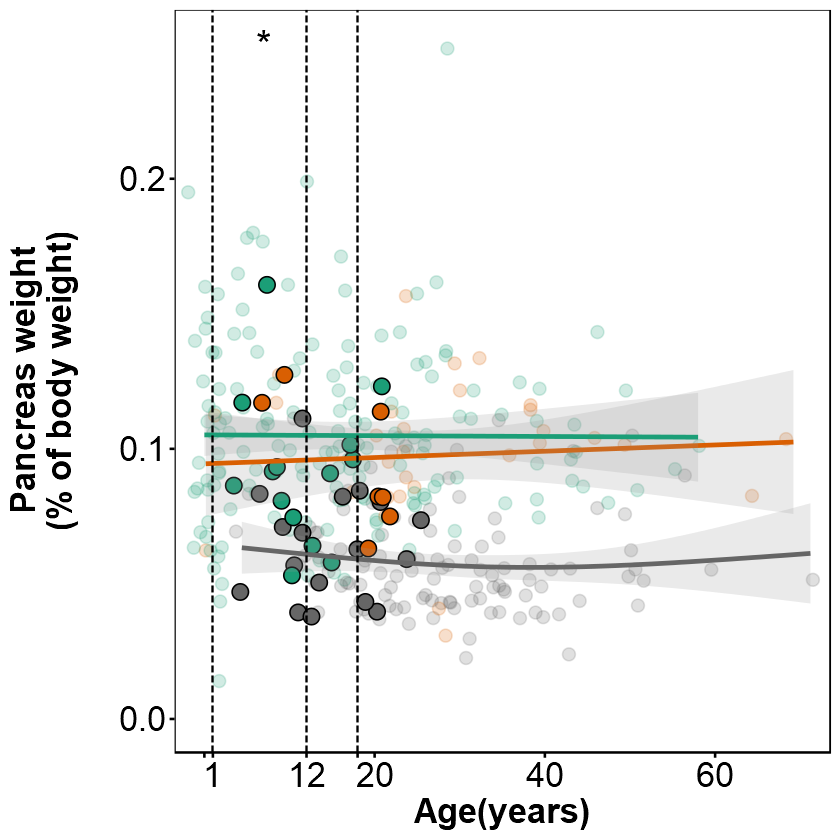

In [107]:
#suppl fig2a 
temp<-import('panc_all.csv')
temp1<-import('panc_limited.csv')


#smoothing fits that were not used
#method="lm", formula = y ~ x + I(x^2)
#method="loess", span=0.7
#method="lm", formula = y ~ poly(x, 2)

#colors
#use #E7298A(pink) to match color palette below.  This is for T1D with no insulin containing islets, and we will use the purple color below as T1D with ICIs.


p <- ggplot(temp, aes(donor_group, relative))
p <- ggplot(temp, aes(oppc_ageR, relative))

supp_fig2a_all<-p  +  
geom_jitter(data=temp, aes(color = DonorType, fill = DonorType), shape=21, width=2, alpha = 0.2, size=3) +
geom_jitter(data=temp1, aes(fill=DonorType),  shape=21, width=2,  alpha = 1, size=4) +
geom_smooth(aes(group = DonorType, color = DonorType), se = TRUE, alpha=0.2, level=0.95, method = "gam", formula = y ~ s(x, k = 3)) + #can specify level=0.95 for 95% confidence interval when se=TRUE, also a family="symmetric" to help control outliers when using LOESS
scale_color_manual(values =c("#D95F02", "#1B9E77", "#666666")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(values=c("No diabetes" = "#1B9E77", "Autoab Pos" = "#D95F02", "T1D" = "#666666")) +  #comment this line out if you want to use R's auto-color palette

theme_few() +
  ylab("Pancreas weight\n(% of body weight)\n") +
  xlab("Age(years)") +
  labs(color = "Donor Group") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)  
  theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
        axis.text=element_text(size=20, color="black", family="Arial"), axis.title=element_text(size=20, face="bold", family="Arial"), axis.ticks=element_line(color="black"),
        panel.border = element_rect(color = "black")) +
  geom_vline(xintercept = c(1,12, 18), linetype = "longdash", color = "black", size=0.5) +
  #annotate(geom = "text", x = 4, y = .17, label = "\u22651", color = "black", size=5, family="Arial") +
  annotate(geom = "text", x = 7, y = .25, label = "*", color = "black", size=8, family="Arial") +
  #annotate(geom = "text", x = 16, y = 3, label = "3", color = "black", size=5, family="Arial") +
  #annotate(geom = "text", x = 45, y = .25, label = "**", color = "black", size=8, family="Arial") +
   coord_cartesian(xlim = c(0, 70))+
scale_y_continuous (limits=c(0.00,.25), breaks=c(0,0.10, 0.20))+
scale_x_continuous(breaks=c(0,1,12,18,20,40,60), labels=c("",1,12,"",20,40,60))

supp_fig2a_all

save_plot("supp_fig2a_all.tiff", supp_fig2a_all, dpi=300, base_aspect_ratio=1.5)

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows fon

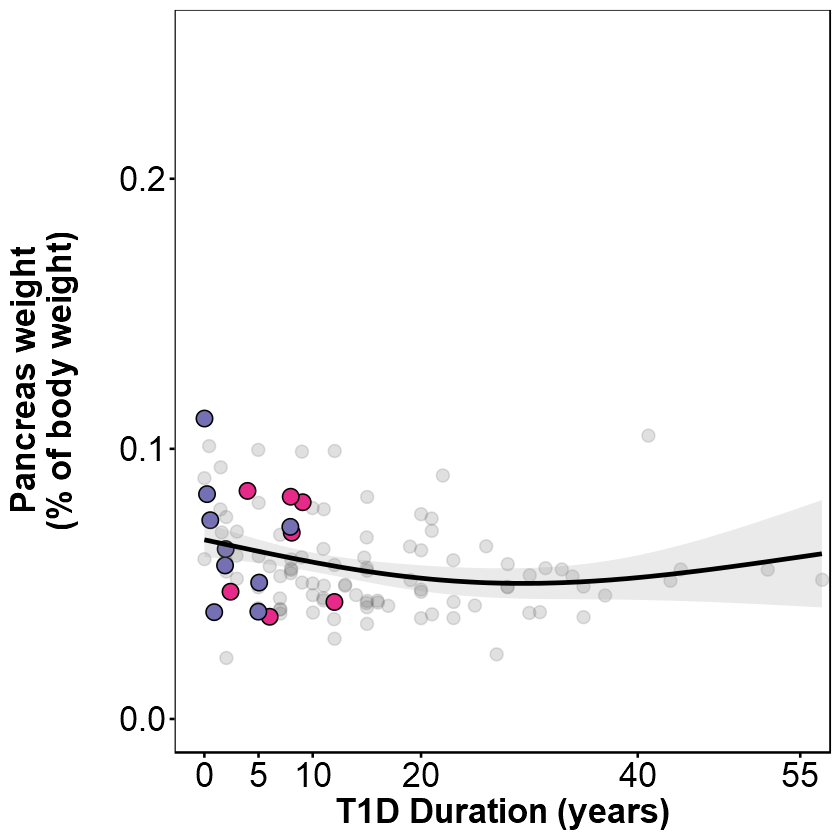

In [108]:
#supp figure 2b 
temp<-import('panc_all_disease_duration.csv')
temp1<-import('panc_limited_disease_duration.csv')

#smoothing fits that were not used
#method="lm", formula = y ~ x + I(x^2)
#method="loess", span=0.7
#method="lm", formula = y ~ poly(x, 2)
#method = "gam", formula = y ~ s(x, k = 3)) 
#colors
#use #E7298A(pink) to match color palette below.  This is for T1D with no insulin containing islets, and we will use the purple color below as T1D with ICIs.


temp %<>% mutate(age_group = ifelse(age_group == "0", "Dev./Neonates",
                                       ifelse(age_group == "1", "Children",
                                              ifelse(age_group == "2", "Adolescents",
                                                    "Adults"))))

temp <- within(temp,age_group <- factor(age_group,
                                            levels=rev(c("Adults",
                                                     "Adolescents",
                                                     "Children",
                                                        "Dev./Neonates"))))

p <- ggplot(temp, aes(donor_group, relative))
p <- ggplot(temp, aes(diabetes_Duration_yrs, relative))

supp_fig2b_all<-p  +  
geom_jitter(aes(color="G", fill="G"), shape=21, alpha = .2, size=3) +
geom_jitter(data=temp1, aes(fill=insulin_positive), shape=21, alpha = 1, size=4) +
geom_smooth(se = TRUE, color="black", alpha=0.2, level=0.95, method="gam", formula = y ~ s(x, k = 3)) + #can specify level=0.95 for 95% confidence interval when se=TRUE, also a family="symmetric" to help control outliers when using LOESS
scale_color_manual(values=c("#666666",  "#E7298A", "#7570B3"))+ 
scale_fill_manual(values=c("#666666",  "#E7298A", "#7570B3"))+

#scale_color_brewer(palette= "PRGn", type="seq")+ #simple way to select color palette
#scale_fill_brewer(palette="PRGn", type="seq")+

#scale_color_manual(values =c("#141204", "#244F26", "#8F3985", "#B3B3B3")) + #custom colors
#  scale_fill_manual(values=c("dev" = "141204", "child" = "#244F26", "adol" = "#8F3985", "adult" = "#B3B3B3")) +  #custom colors
  theme_few() +
  ylab("Pancreas weight\n(% of body weight)\n") +
  xlab("T1D Duration (years)") +
  labs(color = "Donor Group") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)  
  theme(legend.position = "none",legend.text=element_text(size=14, family="Arial"), legend.title=element_blank(),
        axis.text=element_text(size=20, color="black", family="Arial"),  axis.title=element_text(size=20, face="bold", family="Arial"), axis.ticks=element_line(color="black"),
        panel.border = element_rect(color = "black")) +
  #geom_vline(xintercept = c(12, 20), linetype = "longdash", color = "black", size=0.5) 
# annotate(geom = "text", x = 25, y = .25, label = "*", color = "black", size=8, family="Arial") +
 # annotate(geom = "text", x = 16, y = .17, label = "Youth", color = "black", size=6.5, family="Arial") +
 # annotate(geom = "text", x = 23, y = .17, label = "Adults", color = "black", size=6.5, family="Arial") +
  coord_cartesian(xlim = c(0, 55))+
scale_y_continuous (limits=c(0.00,.25), breaks=c(0,0.10, 0.20)) +
scale_x_continuous (limits=c(0,60), breaks=c(0,5,10,20,40,55))

#for customizing legend within plot
#guides(colour = guide_legend(nrow = 1))
#legend.position = c(0.5,0.96)

supp_fig2b_all

save_plot("supp_fig2b_all.tiff", supp_fig2b_all, dpi=300, base_aspect_ratio=1.5)


In [109]:
save_plot("supp_fig2.tiff", plot_grid(supp_fig2a_all, supp_fig2b_all, labels = "AUTO", label_size=20), dpi=300, base_aspect_ratio=1/.30)

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call.graphics(C_t

statistical analysis for supp fig2

In [110]:
data children;
set panc_limited;
if age_group^=1 then delete;
run;

proc mixed data=children;
class donortype npodCaseID oppc_gender ;
model relative=donortype /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans DonorType/adjust=tukey cl pdiff alpha=0.05;
run;

proc sort data=children; by donortype; run;
proc means data=children n mean std median min max;
var relative;
by donortype;
run;


data adult;
set panc_limited;
if age_group^=3 then delete;
run;


proc mixed data=adult;
class donortype npodCaseID oppc_gender;
model relative=donortype /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans DonorType/adjust=tukey cl pdiff alpha=0.05;
run;

proc sort data=adult; by donortype; run;
proc means data=adult n mean std median min max;
var relative;
by donortype;
run;



/*did not analyze either of these age groups due to only having 1 donor in a group*/
data neo;
set panc_limited;
if age_group^=0 then delete;
run;

data adol;
set panc_limited;
if age_group^=2 then delete;
run;

/*tested disease duration differences*/
data t1d;
    set panc_limited;
    if diabetes_duration_yrs="." then delete;
    if relative="." then delete;
    if diabetes_duration_yrs<=5 then disease_bin=0;                     /*new onset*/
    if diabetes_duration_yrs>5 and diabetes_duration_yrs<=10 then disease_bin=1;   /*new onset +*/
    if diabetes_duration_yrs>10 and diabetes_duration_yrs<=20 then disease_bin=2;  /*long duration - */
    if diabetes_duration_yrs>20 then disease_bin=3;   /*long duration*/
run;

proc freq data=t1d;
tables disease_bin;
run;

proc mixed data=t1d;
class npodCaseID oppc_gender disease_bin;
model relative=disease_bin /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans disease_bin/adjust=tukey cl pdiff alpha=0.05;
run;


proc mixed data=t1d;
class npodCaseID oppc_gender disease_bin insulin_positive;
model relative=diabetes_duration_yrs|insulin_positive /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
     lsmeans insulin_positive/adjust=tukey cl pdiff alpha=0.05;
run;

proc mixed data=t1d;
class npodCaseID oppc_gender disease_bin insulin_positive;
model relative=diabetes_duration_yrs insulin_positive /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
     lsmeans insulin_positive/adjust=tukey cl pdiff alpha=0.05;
run;


supplemental figure 1

[1] "region"                           "Region_No"                       
 [3] "INS"                              "Total Tissue  Area (mm²)"        
 [5] "Islet Area (mm²)"                 "Acinar Area (mm²)"               
 [7] "Duct and other Area (mm²)"        "Islet Area (%) out of total tiss"
 [9] "Acinar Area (%) out of total tis" "Duct and Other (%) out of total" 
[11] "Total cells number (acinar +endo" "Total islet cell number"         
[13] "islet:cell density(islet cells/i" "islets: Avg Cell Area (cell size"
[15] "Total acinar cell numbers"        "acinar:cell density(acinar cells"
[17] "acinar: Avg Cell Area (cell size" "acinar: Avg Cytoplasm Area (µm²)"
[19] "acinar: Avg Nucleus Area (µm²)"   "nPODCaseID"                      
[21] "DonorType"                        "percent_endocrine_area"          
[23] "percent_acinar_area"              "percent_remaining_area"          
[25] "endocrine_density"                "acinar_density"                  
[27] "endocrine_cell_size"              "acinar_cell_size"                
[29] "donorgroup"                       "endocrine_cell_size_scale"       
[31] "acinar_cell_size_scale"           "endocrine_cell_size_scale1"      
[33] "acinar_cell_size_scale1"          "mean_percent_endocrine_area"     
[35] "mean_percent_acinar_area"         "mean_percent_remaining_area"     
[37] "mean_endocrine_density"           "mean_acinar_density"             
[39] "mean_endocrine_cell_size"         "mean_endocrine_cell_size_scale1" 
[41] "mean_acinar_cell_size_scale1"     "group_percent_endocrine_area"    
[43] "group_percent_acinar_area"        "group_percent_remaining_area"    
[45] "group_endocrine_density"          "group_acinar_density"            
[47] "group_endocrine_cell_size"        "group_endocrine_cell_size_scale1"
[49] "group_acinar_cell_size_scale1"    "pancreas_region"                 
[51] "donor_range"

donor_range pancreas_region val      
1  No diabetes Head            2.0008790
2  No diabetes Body            1.9673209
3  No diabetes Tail            2.9109851
4  AAb+        Head            1.2927763
5  AAb+        Body            1.5376332
6  AAb+        Tail            2.4773123
7  T1D INS+    Head            0.6938312
8  T1D INS+    Body            0.7619175
9  T1D INS+    Tail            1.2712940
10 T1D INS-    Head            0.4580116
11 T1D INS-    Body            0.8301359
12 T1D INS-    Tail            1.3447566

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, 

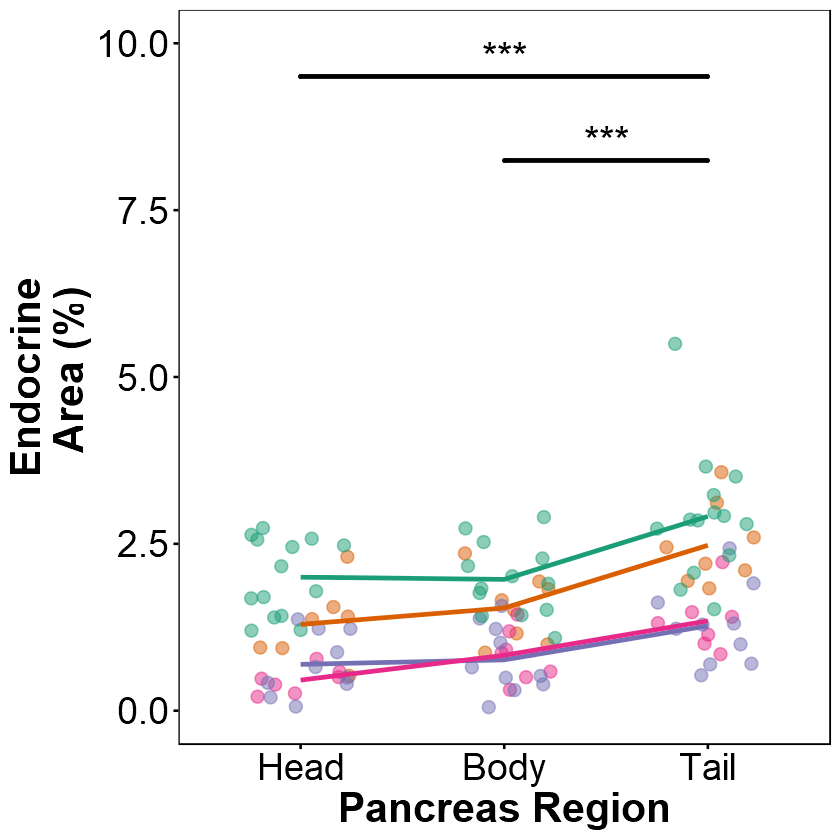

In [111]:
dataset <- import("cell3.csv")

dataset %<>% mutate(pancreas_region = ifelse(region == "PH", "Head",
                                             ifelse(region == "PB", "Body",
                                                    "Tail")),
                    donor_range = ifelse(donorgroup == "No diabetes", "No diabetes",
                                       ifelse(donorgroup == "Autoab Pos", "AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))
dataset$nPODCaseID <- as.character(dataset$nPODCaseID)


#order the variables
dataset <- within(dataset,pancreas_region <- factor(pancreas_region,
                                            levels=rev(c("Tail",
                                                     "Body",
                                                     "Head"))))

dataset <- within(dataset,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                     "AAb+",
                                                        "No diabetes"))))

colnames(dataset)

#need to calculate means at each level of each group, to plot simple effects 
meandataset <- ddply(dataset,.(donor_range,pancreas_region),summarise, val = mean(percent_endocrine_area))
meandataset

p <- ggplot(dataset, aes(pancreas_region, percent_endocrine_area))


suppfig1_1<-p + geom_jitter(aes(color = donor_range), alpha=0.50, size=3, width = 0.25) +
  geom_line(data=meandataset, aes(y=val, group=donor_range, color = donor_range), size=1)+
  scale_color_manual(values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
  scale_fill_manual(values=c("No diabetes" = "#1B9E77", "AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
  theme_few() +
  ylab("Endocrine\n Area (%)") +
  xlab("Pancreas Region") +
  labs(color = "Donor Type") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)    
  theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
        axis.text=element_text(size=22, color="black", family="Arial"), axis.title=element_text(size=24, face="bold", family="Arial", color="black"), axis.ticks=element_line(color="black"),
        panel.border = element_rect(color = "black")) +
        scale_y_continuous(limits=c(0,10))+
      geom_signif(y_position=c(8.25, 9.5), xmin=c(2, 1), xmax=c(3, 3),
              annotation=c("***", "***"), tip_length=0, size=1, color="black", textsize=8) #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html


suppfig1_1
save_plot("suppfig1_1.tiff", suppfig1_1, base_aspect_ratio=1.1)

#ggsave("ESM_Fig3.png", dpi = 600)
#save_plot("ESM_Fig3.tiff", ESM_Fig3, dpi=600, base_aspect_ratio=1.5)

[1] "region"                           "Region_No"                       
 [3] "INS"                              "Total Tissue  Area (mm²)"        
 [5] "Islet Area (mm²)"                 "Acinar Area (mm²)"               
 [7] "Duct and other Area (mm²)"        "Islet Area (%) out of total tiss"
 [9] "Acinar Area (%) out of total tis" "Duct and Other (%) out of total" 
[11] "Total cells number (acinar +endo" "Total islet cell number"         
[13] "islet:cell density(islet cells/i" "islets: Avg Cell Area (cell size"
[15] "Total acinar cell numbers"        "acinar:cell density(acinar cells"
[17] "acinar: Avg Cell Area (cell size" "acinar: Avg Cytoplasm Area (µm²)"
[19] "acinar: Avg Nucleus Area (µm²)"   "nPODCaseID"                      
[21] "DonorType"                        "percent_endocrine_area"          
[23] "percent_acinar_area"              "percent_remaining_area"          
[25] "endocrine_density"                "acinar_density"                  
[27] "endocrine_cell_size"              "acinar_cell_size"                
[29] "donorgroup"                       "endocrine_cell_size_scale"       
[31] "acinar_cell_size_scale"           "endocrine_cell_size_scale1"      
[33] "acinar_cell_size_scale1"          "mean_percent_endocrine_area"     
[35] "mean_percent_acinar_area"         "mean_percent_remaining_area"     
[37] "mean_endocrine_density"           "mean_acinar_density"             
[39] "mean_endocrine_cell_size"         "mean_endocrine_cell_size_scale1" 
[41] "mean_acinar_cell_size_scale1"     "group_percent_endocrine_area"    
[43] "group_percent_acinar_area"        "group_percent_remaining_area"    
[45] "group_endocrine_density"          "group_acinar_density"            
[47] "group_endocrine_cell_size"        "group_endocrine_cell_size_scale1"
[49] "group_acinar_cell_size_scale1"    "pancreas_region"                 
[51] "donor_range"

donor_range pancreas_region val     
1  No diabetes Head            73.38269
2  No diabetes Body            75.91032
3  No diabetes Tail            76.68290
4  AAb+        Head            70.36372
5  AAb+        Body            76.64800
6  AAb+        Tail            78.53774
7  T1D INS+    Head            71.76182
8  T1D INS+    Body            72.80789
9  T1D INS+    Tail            77.34036
10 T1D INS-    Head            72.62985
11 T1D INS-    Body            70.82866
12 T1D INS-    Tail            64.55483

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning m

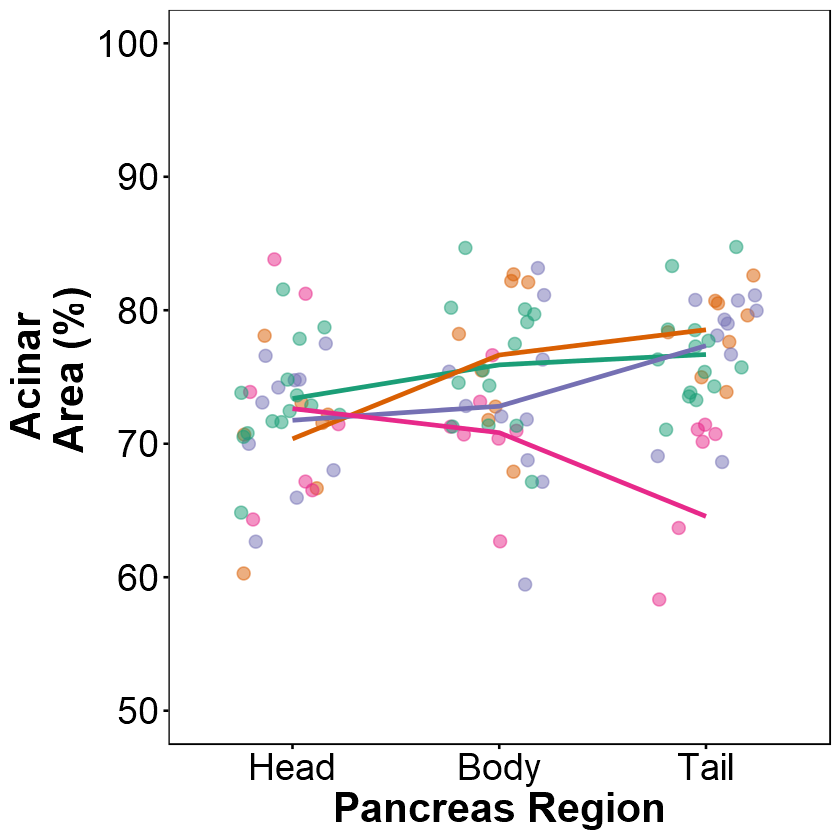

In [112]:
dataset <- import("cell3.csv")

dataset %<>% mutate(pancreas_region = ifelse(region == "PH", "Head",
                                             ifelse(region == "PB", "Body",
                                                    "Tail")),
                    donor_range = ifelse(donorgroup == "No diabetes", "No diabetes",
                                       ifelse(donorgroup == "Autoab Pos", "AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))
dataset$nPODCaseID <- as.character(dataset$nPODCaseID)


#order the variables
dataset <- within(dataset,pancreas_region <- factor(pancreas_region,
                                            levels=rev(c("Tail",
                                                     "Body",
                                                     "Head"))))

dataset <- within(dataset,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                     "AAb+",
                                                        "No diabetes"))))

colnames(dataset)

#need to calculate means at each level of each group, to plot simple effects 
meandataset <- ddply(dataset,.(donor_range,pancreas_region),summarise, val = mean(percent_acinar_area))
meandataset

p <- ggplot(dataset, aes(pancreas_region, percent_acinar_area))


suppfig1_2<-p + geom_jitter(aes(color = donor_range), alpha=0.50, size=3, width = 0.25) +
  geom_line(data=meandataset, aes(y=val, group=donor_range, color = donor_range), size=1)+
  scale_color_manual(values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
  scale_fill_manual(values=c("No diabetes" = "#1B9E77", "AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
  theme_few() +
  ylab("Acinar\n Area (%)") +
  xlab("Pancreas Region") +
  labs(color = "Donor Type") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)    
  theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
        axis.text=element_text(size=22, color="black", family="Arial"), axis.title=element_text(size=24, face="bold", family="Arial", color="black"), axis.ticks=element_line(color="black"),
        panel.border = element_rect(color = "black")) +
        scale_y_continuous(limits=c(50,100))

suppfig1_2
save_plot("suppfig1_2.tiff", suppfig1_2, base_aspect_ratio=1.1)

#ggsave("ESM_Fig3.png", dpi = 600)
#save_plot("ESM_Fig3.tiff", ESM_Fig3, dpi=600, base_aspect_ratio=1.5)

[1] "region"                           "Region_No"                       
 [3] "INS"                              "Total Tissue  Area (mm²)"        
 [5] "Islet Area (mm²)"                 "Acinar Area (mm²)"               
 [7] "Duct and other Area (mm²)"        "Islet Area (%) out of total tiss"
 [9] "Acinar Area (%) out of total tis" "Duct and Other (%) out of total" 
[11] "Total cells number (acinar +endo" "Total islet cell number"         
[13] "islet:cell density(islet cells/i" "islets: Avg Cell Area (cell size"
[15] "Total acinar cell numbers"        "acinar:cell density(acinar cells"
[17] "acinar: Avg Cell Area (cell size" "acinar: Avg Cytoplasm Area (µm²)"
[19] "acinar: Avg Nucleus Area (µm²)"   "nPODCaseID"                      
[21] "DonorType"                        "percent_endocrine_area"          
[23] "percent_acinar_area"              "percent_remaining_area"          
[25] "endocrine_density"                "acinar_density"                  
[27] "endocrine_cell_size"              "acinar_cell_size"                
[29] "donorgroup"                       "endocrine_cell_size_scale"       
[31] "acinar_cell_size_scale"           "endocrine_cell_size_scale1"      
[33] "acinar_cell_size_scale1"          "mean_percent_endocrine_area"     
[35] "mean_percent_acinar_area"         "mean_percent_remaining_area"     
[37] "mean_endocrine_density"           "mean_acinar_density"             
[39] "mean_endocrine_cell_size"         "mean_endocrine_cell_size_scale1" 
[41] "mean_acinar_cell_size_scale1"     "group_percent_endocrine_area"    
[43] "group_percent_acinar_area"        "group_percent_remaining_area"    
[45] "group_endocrine_density"          "group_acinar_density"            
[47] "group_endocrine_cell_size"        "group_endocrine_cell_size_scale1"
[49] "group_acinar_cell_size_scale1"    "pancreas_region"                 
[51] "donor_range"

donor_range pancreas_region val     
1  No diabetes Head            24.61643
2  No diabetes Body            22.12236
3  No diabetes Tail            20.40611
4  AAb+        Head            28.34350
5  AAb+        Body            21.81436
6  AAb+        Tail            18.98495
7  T1D INS+    Head            27.54435
8  T1D INS+    Body            26.43019
9  T1D INS+    Tail            21.38835
10 T1D INS-    Head            26.91214
11 T1D INS-    Body            28.34120
12 T1D INS-    Tail            34.10041

Warning message:
"Removed 1 rows containing non-finite values (stat_signif)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$

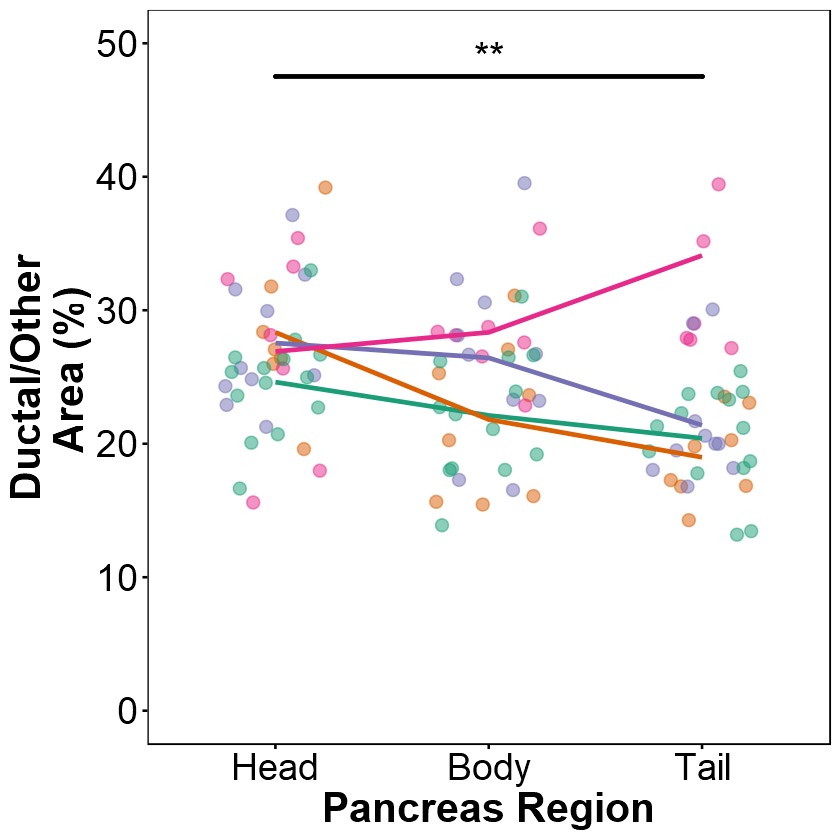

In [113]:
dataset <- import("cell3.csv")

dataset %<>% mutate(pancreas_region = ifelse(region == "PH", "Head",
                                             ifelse(region == "PB", "Body",
                                                    "Tail")),
                    donor_range = ifelse(donorgroup == "No diabetes", "No diabetes",
                                       ifelse(donorgroup == "Autoab Pos", "AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))
dataset$nPODCaseID <- as.character(dataset$nPODCaseID)


#order the variables
dataset <- within(dataset,pancreas_region <- factor(pancreas_region,
                                            levels=rev(c("Tail",
                                                     "Body",
                                                     "Head"))))

dataset <- within(dataset,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                     "AAb+",
                                                        "No diabetes"))))

colnames(dataset)

#need to calculate means at each level of each group, to plot simple effects 
meandataset <- ddply(dataset,.(donor_range,pancreas_region),summarise, val = mean(percent_remaining_area))
meandataset

p <- ggplot(dataset, aes(pancreas_region, percent_remaining_area))


suppfig1_3<-p + geom_jitter(aes(color = donor_range), alpha=0.50, size=3, width = 0.25) +
  geom_line(data=meandataset, aes(y=val, group=donor_range, color = donor_range), size=1)+
  scale_color_manual(values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
  scale_fill_manual(values=c("No diabetes" = "#1B9E77", "AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
  theme_few() +
  ylab("Ductal/Other\n Area (%)") +
  xlab("Pancreas Region") +
  labs(color = "Donor Type") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)    
  theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
        axis.text=element_text(size=22, color="black", family="Arial"), axis.title=element_text(size=24, face="bold", family="Arial", color="black"), axis.ticks=element_line(color="black"),
        panel.border = element_rect(color = "black"))+
        scale_y_continuous(limits=c(0,50)) +
      geom_signif(y_position=c(47.5), xmin=c(1), xmax=c(3),
              annotation=c("**"), tip_length=0, size=1, color="black", textsize=8) #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html

suppfig1_3
save_plot("suppfig1_3.tiff", suppfig1_3, base_aspect_ratio=1.1)
#ggsave("ESM_Fig3.png", dpi = 600)
#save_plot("ESM_Fig3.tiff", ESM_Fig3, dpi=600, base_aspect_ratio=1.5)

In [114]:
suppfig1<-plot_grid(suppfig1_1, suppfig1_2,  suppfig1_3, nrow=1, ncol=3, 
                #labels="B", 
                #label_size=30,
               label_x=0,
               label_y=1)





#features like expand=() expand_limits()  expand=expand_scale()

save_plot("suppfig1.tiff", suppfig1, ncol=3, nrow=1, base_aspect_ratio=1.1)

Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing non-finite values (stat_signif)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows fon

statistical analysis for supplemental figure 1 and figure 3a

In [115]:
/*this macro is used for other figures besides supp figure 1.
this macro is used to analyze critical cell and duct endpoints using mixed model.  
First step is to explore the best covariance structure for each endpoint, then identify if differences exist.  */

/*
Covariance structures considered include:
homogeneous covariance structures
vc - simpJlist, correlation of errors assumed to be 0
cs - compound symmetry, constant variance and covariance

heterogeneous covariance structure
un - unstructured, most complex
unr- unstructured correlation
un(1) - banded main diagonal
csh - heterogeneous compound symmetry
hf - Huynh-Feldt (similar to csh) 
arh(1) - autoregressive heterogeneous
*/


%macro explore (a);

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=vc; 
     ods output FitStatistics=Fitvc(rename=(value=vc)) Dimensions=Parmvc(rename=(value=Numvc)) ConvergenceStatus=ConvergeStatusvc; 
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusvc;
    set ConvergeStatusvc;
    covar="vc ";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=cs; 
     ods output FitStatistics=Fitcs(rename=(value=cs)) Dimensions=Parmcs(rename=(value=Numcs)) ConvergenceStatus=ConvergeStatuscs;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatuscs;
    set ConvergeStatuscs;
    covar="cs ";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution;/*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=un; 
     ods output FitStatistics=Fitun(rename=(value=un)) Dimensions=Parmun(rename=(value=Numun)) ConvergenceStatus=ConvergeStatusun;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusun;
    set ConvergeStatusun;
    covar="un ";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=unr; 
     ods output FitStatistics=Fitunr(rename=(value=unr)) Dimensions=Parmunr(rename=(value=Numunr)) ConvergenceStatus=ConvergeStatusunr;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusunr;
    set ConvergeStatusunr;
    covar="unr";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un(1); 
     ods output FitStatistics=Fitun1(rename=(value=un1)) Dimensions=Parmun1(rename=(value=Numun1)) ConvergenceStatus=ConvergeStatusun1;  
     parms/ols;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusun1;
    set ConvergeStatusun1;
    covar="un1";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=csh; 
     ods output FitStatistics=Fitcsh(rename=(value=csh)) Dimensions=Parmcsh(rename=(value=Numcsh)) ConvergenceStatus=ConvergeStatuscsh; 
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatuscsh;
    set ConvergeStatuscsh;
    covar="csh";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=hf; 
     ods output FitStatistics=Fithf(rename=(value=hf)) Dimensions=Parmhf(rename=(value=Numhf)) ConvergenceStatus=ConvergeStatushf;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatushf;
    set ConvergeStatushf;
    covar="hf ";
RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=arh(1); 
     ods output FitStatistics=Fitarh1(rename=(value=arh1)) Dimensions=Parmarh1(rename=(value=Numarh1)) ConvergenceStatus=ConvergeStatusarh1;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusarh1;
    set ConvergeStatusarh1;
    covar="arh(1) ";
RUN;

DATA all;
    merge work.fit:;
RUN;

/*above merge line merges all files with the prefix fit.  The reason for this instead of spelling out each file is because 
some fitstatistics files do not exist for each covar structure tested*/

PROC print data=all label noobs;
RUN;

DATA STATUS;
    set ConvergeStatus:;
RUN;

proc print data=status; run;

%mend explore;



In [116]:
%explore(percent_endocrine_area);

In [117]:
proc sort data=cell3;
by region;
run;

PROC freq data=cell3;
tables donorgroup;
by region;
run;


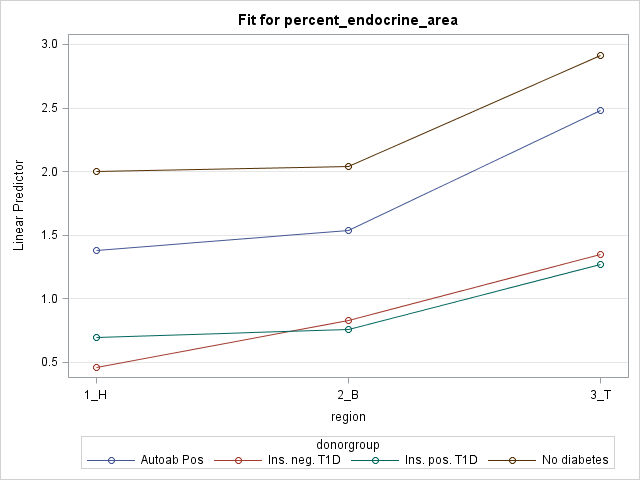

In [118]:
PROC format;
     value $regionformat
     'PH' = '1_H'
     'PB' = '2_B'
     'PT' = '3_T';
     RUN;

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
format region $regionformat.;
class nPODCaseID donorgroup region;
     model  percent_endocrine_area= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=csh; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
     store endocrine_model_data;
run;


/*even though not significant, showing interaction data*/
proc plm restore=endocrine_model_data;
effectplot interaction(sliceby=donorgroup);
slice donorgroup*region/sliceby=donorgroup diff adjust=tukey cl pdiff alpha=0.05 plots=none nof means;
run;


In [119]:
%explore(percent_acinar_area);


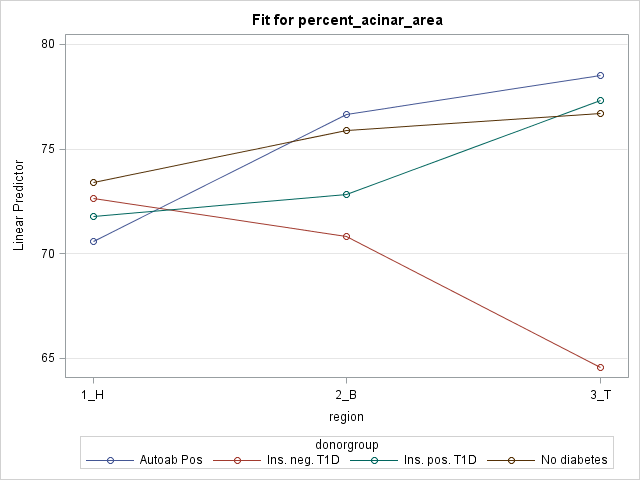

In [120]:

PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  percent_acinar_area =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup) type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
     store acinar_model_data;
run;

/*for interaction term, reporting lsmeans and SE vs arithmetic means and SD, since not all data is balanced;
however, lsmeans and arithemic means are largely identical when data not missing

PROC means data=cell3 n mean std ;
class donorgroup region;
types () donorgroup*region;
var percent_acinar_area;
run;
*/


proc plm restore=acinar_model_data;
effectplot interaction(sliceby=donorgroup);
slice donorgroup*region/sliceby=donorgroup diff adjust=tukey cl pdiff alpha=0.05 plots=none nof means;
run;


In [121]:
%explore(percent_remaining_area);


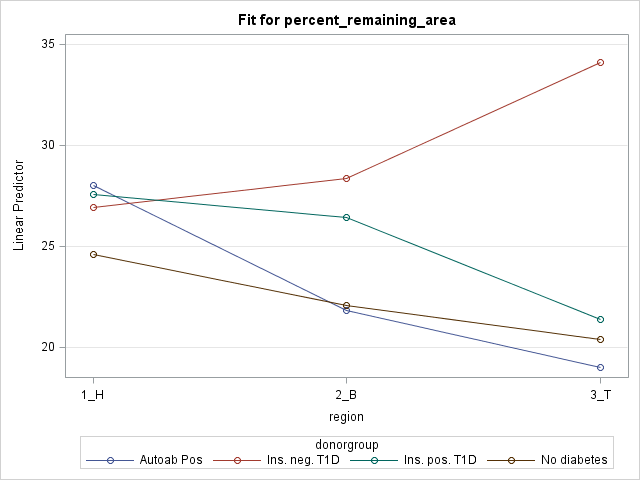

In [122]:
PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  percent_remaining_area =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
       store remaining_model_data;
run;

proc plm restore=remaining_model_data;
effectplot interaction(sliceby=donorgroup);
slice donorgroup*region/sliceby=donorgroup diff adjust=tukey cl pdiff alpha=0.05 plots=none nof means;
run;

### Figure 3b

for figure 3b: evaluate weight in all three tissue types.  formula for mass (g per pancreas) is  the ratio of tissue area (sub-tissue area/whole pancreas tissue areas) times whole pancreas weight

In [123]:
DATA allclinical;
    set clinical1;
    if pancreas_received_intact="FALSE" then delete;
    if whole_pancreas_g=. then delete;
    if oppc_weightR=. then delete;
    weight_g=oppc_weightR*1000;

    
    /*bring in finding from study regarding insulin positivity (main data)*/
    insulin_positive="INS+";
    if npodcaseid=6062 then insulin_positive="INS-";
    if npodcaseid=6079 then insulin_positive="INS-";
    if npodcaseid=6087 then insulin_positive="INS-";
    if npodcaseid=6360 then insulin_positive="INS-";
    if npodcaseid=6064 then insulin_positive="INS-";
    if npodcaseid=6089 then insulin_positive="INS-";
    if npodcaseid=6237 then insulin_positive="INS-";
RUN;

PROC sort data=allclinical;
    by npodcaseID;
RUN;

DATA area (keep= npodcaseID mean_percent_endocrine_area mean_percent_acinar_area mean_percent_remaining_area);
    set cell3_combined_donorgroup;
RUN;


PROC sort data=area out=area1 noduprecs;
    by _all_;
RUN;


DATA weight;
    merge allclinical(in=a) area1 (in=b);
    by npodcaseID;
    if b;
RUN;

/* 
to calculate sub-tissue as percentage of pancreas weight:     endocrine_weight=((mean_percent_endocrine_area/100)*(whole_pancreas_g))/whole_pancreas_g*100;
to calculate sub-tissue as percentage of whole body weight: endocrine_weight=((mean_percent_endocrine_area/100)*(whole_pancreas_g))/weight_g*100;

*/

DATA weight1;
    set weight;
    endocrine_weight=((mean_percent_endocrine_area/100)*(whole_pancreas_g))/weight_g*100; 
    acinar_weight=((mean_percent_acinar_area/100)*(whole_pancreas_g))/weight_g*100;
    remaining_weight=((mean_percent_remaining_area/100)*(whole_pancreas_g))/weight_g*100;
    total_weight=endocrine_weight + acinar_weight + remaining_weight;
    donor_group_specific="          ";
    if donortype="No diabetes" then donor_group_specific="ND";
    if donortype="Autoab Pos" then donor_group_specific="AAb+";
    if donortype="T1D" and insulin_positive="INS+" then donor_group_specific="T1D INS+";
    if donortype="T1D" and insulin_positive="INS-" then donor_group_specific="T1D INS-";
    
    endocrine_weight1=((mean_percent_endocrine_area/100)*(whole_pancreas_g));
    acinar_weight1=((mean_percent_acinar_area/100)*(whole_pancreas_g));
    remaining_weight1=((mean_percent_remaining_area/100)*(whole_pancreas_g));
    total_weight1=endocrine_weight1 + acinar_weight1 + remaining_weight1;
    
    
    
RUN;


PROC sort data=weight1;
by donor_group_specific;
run;


PROC means data=weight1 n mean std median min max;
by donor_group_specific;
var endocrine_weight acinar_weight remaining_weight total_weight relative;
run;

proc export data=weight1
     outfile="&location\Data\weight_wide.csv" 
     dbms=csv
     replace;
run;


/*prep for graphing in R*/
PROC sort data=weight1;
by nPODCaseID donor_group_specific;
run;

PROC transpose data=weight1 out=weight2;
    by nPODCaseID donor_group_specific;
    var endocrine_weight acinar_weight remaining_weight;
RUN;

DATA weight2;
    set weight2;
    rename _NAME_=tissue;
    if col1=. then delete;
RUN;

proc export data=weight2
     outfile="&location\Data\weight_long.csv" 
     dbms=csv
     replace;
run;

  look at association between c-peptide and various weights

In [124]:
proc corr data=weight1; 
var oppc_c_peptideR1 endocrine_weight1 acinar_weight1 remaining_weight1 total_weight1 mean_percent_endocrine_area mean_percent_acinar_area mean_percent_remaining_area;
run;

statistical analysis for figure 3b

In [125]:
proc mixed data=weight1;
class donor_group_specific npodCaseID;
model endocrine_weight=donor_group_specific /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans donor_group_specific/adjust=tukey cl pdiff alpha=0.05;
/*parms/ols does not fix the problem that the convergence criteria was met but final hessian is not positive definitive.  This warning is caused
by the magnitidue of the numbers (very small).*/
run;

In [126]:
proc mixed data=weight1;
class donor_group_specific npodCaseID;
model acinar_weight=donor_group_specific /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans donor_group_specific/adjust=tukey cl pdiff alpha=0.05;
parms /ols;
run;

In [127]:
proc mixed data=weight1;
class donor_group_specific npodCaseID;
model remaining_weight=donor_group_specific /solution ddfm = kenwardroger;
random int/ subject=nPODCaseid;
lsmeans donor_group_specific/adjust=tukey cl pdiff alpha=0.05;
parms /ols;
run;

figure 3b

Warning message:
"Duplicated aesthetics after name standardisation: colour"
Warning message:
"Use of `boxplot$donor_range` is discouraged. Use `donor_range` instead."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.g

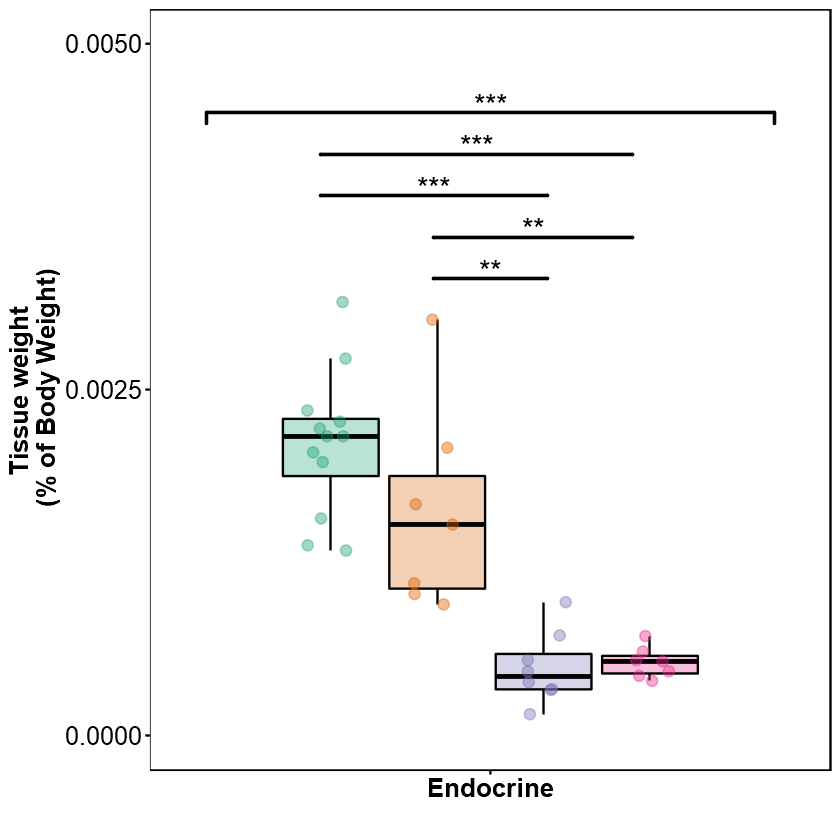

In [128]:
boxplot<-import("weight_long.csv")


boxplot %<>% mutate(donor_range = ifelse(donor_group_specific == "ND", "ND AAb-",
                                              ifelse(donor_group_specific == "AAb+", "ND AAb+",
                                                   ifelse(donor_group_specific == "T1D INS+", "T1D INS+",
                                                    "T1D INS-"))))

boxplot <- within(boxplot,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                         "ND AAb+",
                                                           "ND AAb-"))))


boxplot %<>% mutate(region = ifelse(tissue== "endocrine_weight", "Endocrine",
                                             ifelse(tissue == "acinar_weight", "Acinar",
                                                 "Ductal/Other")))
                                                    

# for reordering the columns
boxplot <- within(boxplot,region <- factor(region,
                                            levels=rev(c("Ductal/Other",
                                                     "Acinar",
                                                     "Endocrine"))))


boxplot <- boxplot[boxplot$region == "Endocrine",]

#boxplots defaults used, i.e. box represents IQR, whiskers 1.5*IQR, beyond whiskers are outliers, and line within box is the median.  
fig<-ggplot(boxplot, aes(region,COL1)) +
geom_boxplot(outlier.size=NA, outlier.color=NA, color="black", alpha=0.3, show.legend=FALSE, color=boxplot$donor_range, aes(fill=donor_range)) +
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("ND AAb-" = "#1B9E77", "ND AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette

geom_jitter(aes(region,COL1, color=boxplot$donor_range, group=donor_range),
        position=position_jitterdodge(jitter.width = .25),   
        alpha=.4,
        size=2.5,
        show.legend=FALSE)+

#geom_point(aes(region,COL1, color=donor_range, group=donor_range), 
#           position = position_dodge(width=.75),
#          alpha=0.5,
#          size=3,
#          show.legend=FALSE) +


    xlab("") +
    ylab("Tissue weight\n (% of Body Weight)") +
theme(axis.title = element_text(size=15,color='black', family="Arial", face="bold"),
          axis.text.y = element_text(size=15,color='black', family="Arial"), 
          axis.text.x=element_text (size=15,color='black', family="Arial", face="bold"),
          axis.ticks=element_line(color="black"),
          panel.background=element_blank())+
     panel_border(colour = "black", size = 0.5, linetype = 1, remove = FALSE)+
     geom_signif(y_position=c(0.0033, 0.0036, 0.0039, 0.0042), xmin=c(.9, .9, .7, .7), xmax=c(1.1, 1.25, 1.1, 1.25),
     annotation=c("**", "**", "***", "***"), tip_length=0, size=.75, textsize=6, color="black", vjust=0.45) + #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html

     geom_signif(y_position=c(0.0045), xmin=c(.50), xmax=c(1.50),
     annotation=c( "***"), tip_length=.025, size=.75, textsize=6, color="black", vjust=0.45) +
scale_y_continuous(limits = c(0, 0.0050), breaks=c(0,0.0025, 0.0050)) 




fig 

save_plot("fig3b_1.tiff", fig, base_aspect_ratio=1/.90)

Warning message:
"Duplicated aesthetics after name standardisation: colour"
Warning message:
"Use of `boxplot$donor_range` is discouraged. Use `donor_range` instead."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.g

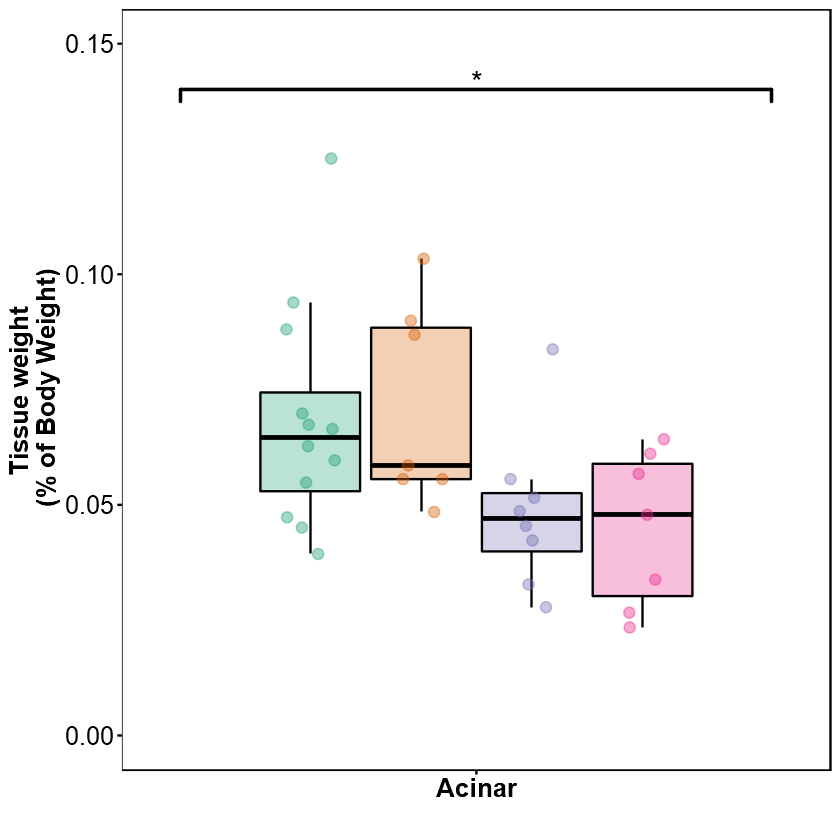

In [129]:
boxplot<-import("weight_long.csv")


boxplot %<>% mutate(donor_range = ifelse(donor_group_specific == "ND", "ND AAb-",
                                              ifelse(donor_group_specific == "AAb+", "ND AAb+",
                                                   ifelse(donor_group_specific == "T1D INS+", "T1D INS+",
                                                    "T1D INS-"))))

boxplot <- within(boxplot,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                         "ND AAb+",
                                                           "ND AAb-"))))


boxplot %<>% mutate(region = ifelse(tissue== "endocrine_weight", "Endocrine",
                                             ifelse(tissue == "acinar_weight", "Acinar",
                                                 "Ductal/Other")))
                                                    

# for reordering the columns
boxplot <- within(boxplot,region <- factor(region,
                                            levels=rev(c("Ductal/Other",
                                                     "Acinar",
                                                     "Endocrine"))))

boxplot <- boxplot[boxplot$region == "Acinar",]
#boxplots defaults used, i.e. box represents IQR, whiskers 1.5*IQR, beyond whiskers are outliers, and line within box is the median.  
fig<-ggplot(boxplot, aes(region,COL1)) +
geom_boxplot(outlier.size=NA, outlier.color=NA, color="black", alpha=0.3, show.legend=FALSE, color=boxplot$donor_range, aes(fill=donor_range)) +
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("ND AAb-" = "#1B9E77", "ND AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette

geom_jitter(aes(region,COL1, color=boxplot$donor_range, group=donor_range),
        position=position_jitterdodge(jitter.width = .25),   
        alpha=.4,
        size=2.5,
        show.legend=FALSE)+

#geom_point(aes(region,COL1, color=donor_range, group=donor_range), 
#           position = position_dodge(width=.75),
#          alpha=0.5,
#          size=3,
#          show.legend=FALSE) +


    xlab("") +
    ylab("Tissue weight\n (% of Body Weight)") +
theme(axis.title = element_text(size=15,color='black', family="Arial", face="bold"),
          axis.text.y = element_text(size=15,color='black', family="Arial"), 
          axis.text.x=element_text (size=15,color='black', family="Arial", face="bold"),
          axis.ticks=element_line(color="black"),
          panel.background=element_blank())+
     panel_border(colour = "black", size = 0.5, linetype = 1, remove = FALSE)+
     geom_signif(y_position=c(0.14), xmin=c(.50), xmax=c(1.50),
     annotation=c( "*"), tip_length=.025, size=.75, textsize=6, color="black", vjust=0.45) +

scale_y_continuous(limits = c(0, 0.15), breaks=c(0, 0.05, 0.1, 0.15)) 




fig 

save_plot("fig3b_2.tiff", fig, base_aspect_ratio=1/.90)

Warning message:
"Duplicated aesthetics after name standardisation: colour"
Warning message:
"Use of `boxplot$donor_range` is discouraged. Use `donor_range` instead."
Warning message:
"Removed 6 rows containing missing values (geom_signif)."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not foun

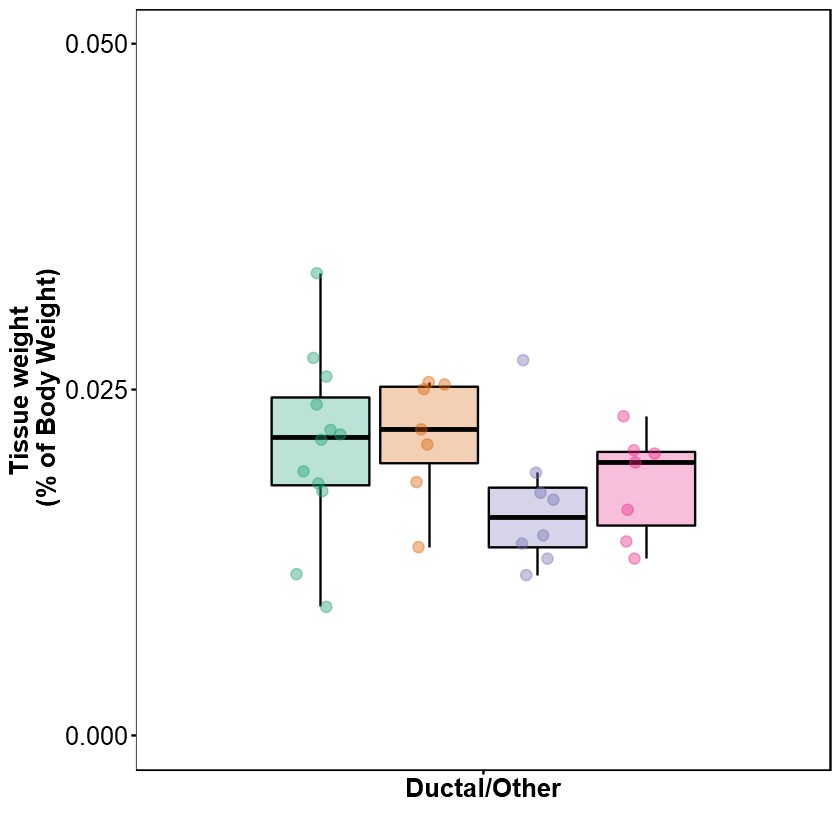

In [130]:
boxplot<-import("weight_long.csv")


boxplot %<>% mutate(donor_range = ifelse(donor_group_specific == "ND", "ND AAb-",
                                              ifelse(donor_group_specific == "AAb+", "ND AAb+",
                                                   ifelse(donor_group_specific == "T1D INS+", "T1D INS+",
                                                    "T1D INS-"))))

boxplot <- within(boxplot,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                         "ND AAb+",
                                                           "ND AAb-"))))


boxplot %<>% mutate(region = ifelse(tissue== "endocrine_weight", "Endocrine",
                                             ifelse(tissue == "acinar_weight", "Acinar",
                                                 "Ductal/Other")))
                                                    

# for reordering the columns
boxplot <- within(boxplot,region <- factor(region,
                                            levels=rev(c("Ductal/Other",
                                                     "Acinar",
                                                     "Endocrine"))))

boxplot <- boxplot[boxplot$region == "Ductal/Other",]
#boxplots defaults used, i.e. box represents IQR, whiskers 1.5*IQR, beyond whiskers are outliers, and line within box is the median.  
fig<-ggplot(boxplot, aes(region,COL1)) +
geom_boxplot(outlier.size=NA, outlier.color=NA, color="black", alpha=0.3, show.legend=FALSE, color=boxplot$donor_range, aes(fill=donor_range)) +
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("ND AAb-" = "#1B9E77", "ND AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette

geom_jitter(aes(region,COL1, color=boxplot$donor_range, group=donor_range),
        position=position_jitterdodge(jitter.width = .25),   
        alpha=.4,
        size=2.5,
        show.legend=FALSE)+

#geom_point(aes(region,COL1, color=donor_range, group=donor_range), 
#           position = position_dodge(width=.75),
#          alpha=0.5,
#          size=3,
#          show.legend=FALSE) +


    xlab("") +
    ylab("Tissue weight\n (% of Body Weight)") +
theme(axis.title = element_text(size=15,color='black', family="Arial", face="bold"),
          axis.text.y = element_text(size=15,color='black', family="Arial"), 
          axis.text.x=element_text (size=15,color='black', family="Arial", face="bold"),
          axis.ticks=element_line(color="black"),
          panel.background=element_blank())+
     panel_border(colour = "black", size = 0.5, linetype = 1, remove = FALSE)+
     geom_signif(y_position=c(42, 48), xmin=c( 0.7, 0.9), xmax=c(1.28, 1.28),
     annotation=c( "*", "*"), tip_length=0, size=.75, textsize=6, color="black", vjust=0.45) + #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html
scale_y_continuous(limits = c(0, 0.05), breaks=c(0,0.025, 0.05)) 




fig 

save_plot("fig3b_3.tiff", fig, base_aspect_ratio=1/.90)

### Figure 3a

figure 3a: main effects visualization - differences in endocrine, acinar, ductal cell area by donortype.  Statistics for this figure are in the supplemental figure 1 section

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"


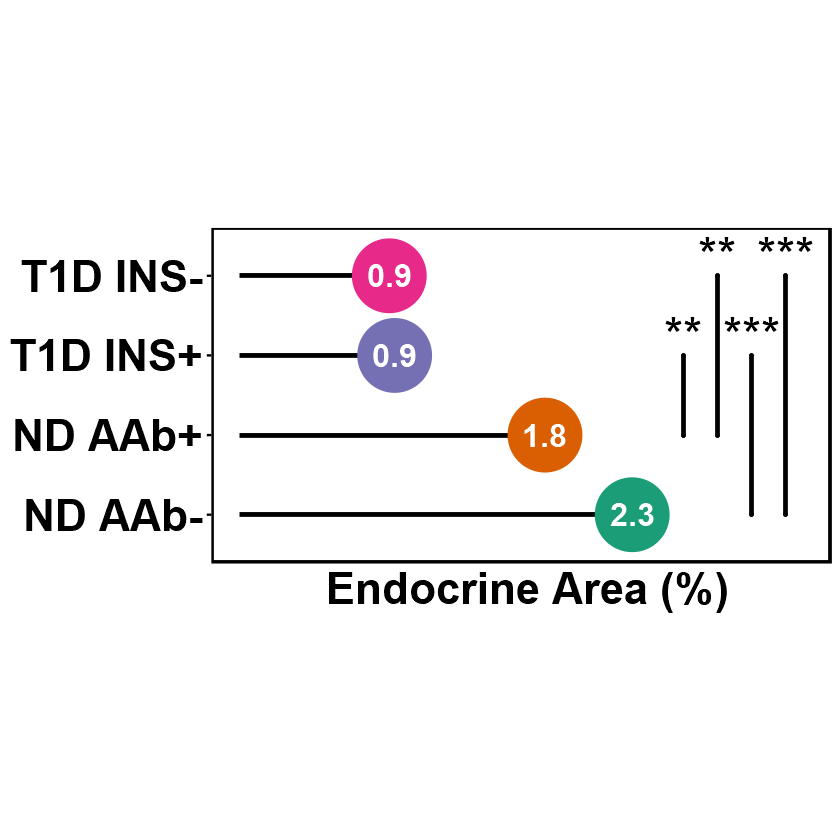

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"


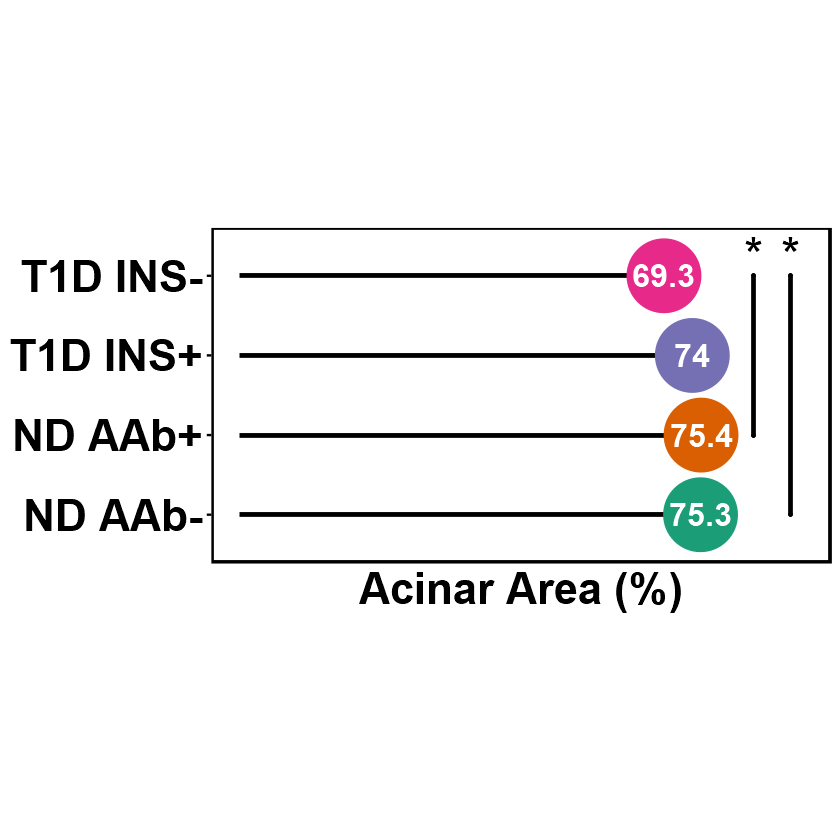

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"


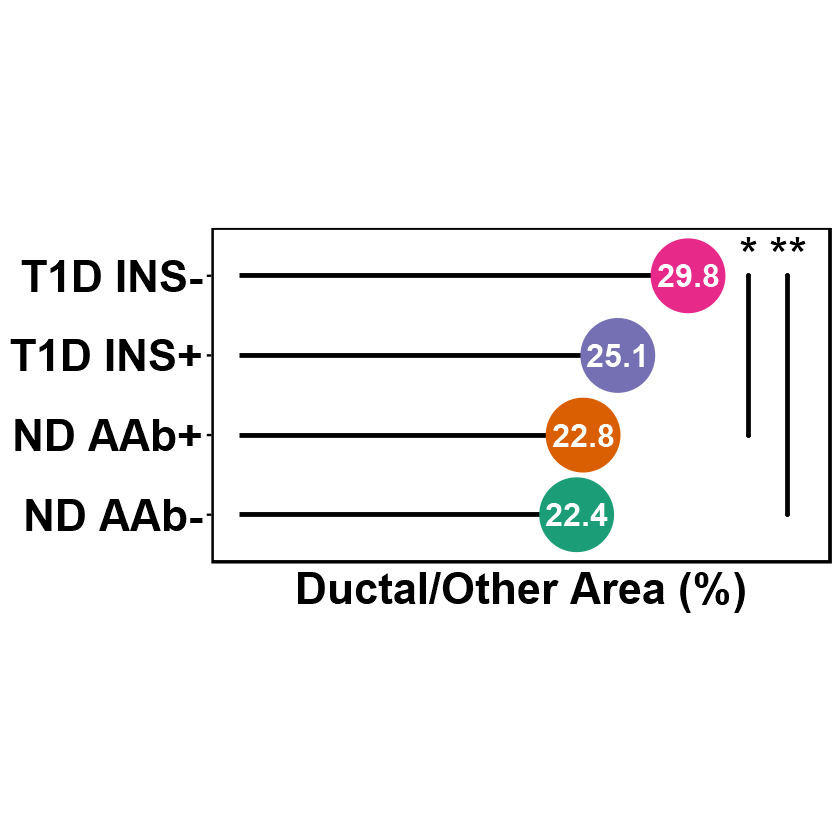

In [131]:
lollipop<-import("cell3_lollipop.csv")

lollipop %<>% mutate(donorgroup1 = ifelse(donorgroup == "No diabetes", "ND AAb-",
                                       ifelse(donorgroup == "Autoab Pos", "ND AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))

#lollipop <- within(lollipop,donorgroup1 <- factor(donorgroup1,
#                                            levels=rev(c("T1D INS-",
#                                                     "T1D INS+",
#                                                     "ND AAb+",
#                                                        "ND AAb-"))))


endocrine<-ggdotchart (lollipop, x="donorgroup1", y="group_percent_endocrine_area",
            color=c("#1B9E77", "#D95F02", "#7570B3", "#E7298A"), #color
            palette=c("#1B9E77", "#D95F02", "#7570B3", "#E7298A"), #color
            add="segments", #line to lollipop
            add.params = list(color = c("black"), size = 1), #line color
            label = round(lollipop$group_percent_endocrine_area,1), font.label = list(color = "white", size = 20, vjust=0.5, face = "bold"), #label 
            rotate=TRUE, #rotate from vertical to horizonal
            dot.size=20, #change dote size
            xlab=TRUE, ylab=FALSE, #hide label
            ggtheme=theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
            axis.text=element_text(size=26, color="black", family="Arial", face="bold"), 
            axis.title.x=element_text(size=26, face="bold", family="Arial"), axis.ticks.x=element_blank(), 
            aspect.ratio=.54, panel.background = element_blank()))+
            panel_border(colour = "black", size = 1, linetype = 1, remove = FALSE) +
        scale_x_discrete(limits=c("ND AAb-", "ND AAb+", "T1D INS+", "T1D INS-"), labels=c("ND AAb-","ND AAb+","T1D INS+","T1D INS-")) +
        scale_y_continuous(name=" Endocrine Area (%)", limits=c(0,3.3), labels=c()) +
#geom_shadowtext(label=round(lollipop$group_percent_endocrine_area,1), color = "white", size = 7, vjust=0.5, face = "bold")
     geom_signif(y_position=c(2.6, 2.8, 3.0, 3.2), xmin=c(2,2, 1, 1),xmax=c(3,4, 3,4),
              annotation=c("**", "**", "***","***"), tip_length=0, size=1, color="black", textsize=10) #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html

endocrine
save_plot("fig3a1.tiff", endocrine, base_aspect_ratio=1.7)

acinar<-ggdotchart (lollipop, x="donorgroup1", y="group_percent_acinar_area",
            color=c("#D95F02", "#1B9E77", "#7570B3", "#E7298A"), #color
             palette=c("#D95F02", "#1B9E77", "#7570B3", "#E7298A"), #color
             add="segments", #line to lollipop
            add.params = list(color = c("black"), size = 1), #line color
              label = round(lollipop$group_percent_acinar_area,1), font.label = list(color = "white", size = 20, vjust=0.5, face = "bold"), #label 
            rotate=TRUE, #rotate from vertical to horizonal
            dot.size=20, #change dote size
            xlab=TRUE, ylab=FALSE, #hide label
            ggtheme=theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
            axis.text=element_text(size=26, color="black", family="Arial", face="bold"), 
            axis.title.x=element_text(size=26, face="bold", family="Arial"), axis.ticks.x=element_blank(), 
            aspect.ratio=.54, panel.background = element_blank()))+
            panel_border(colour = "black", size = 1, linetype = 1, remove = FALSE) +
        scale_x_discrete(limits=c("ND AAb-", "ND AAb+", "T1D INS+", "T1D INS-"), labels=c("ND AAb-","ND AAb+","T1D INS+","T1D INS-")) +
        scale_y_continuous(name="Acinar Area (%)", limits=c(0, 92), labels=c())+
#geom_shadowtext(label=round(lollipop$group_percent_acinar_area,1), color = "white", size = 7, vjust=0.5, face = "bold")
        geom_signif(comparisons=list(c("ND AAb+", "T1D INS-")),
                      y_position = 84, annotation=c("*"), tip_length=0, size=1, color="black", textsize=10) +
        geom_signif(comparisons=list(c("ND AAb-", "T1D INS-")),
                      y_position = 90, annotation=c("*"), tip_length=0, size=1, color="black", textsize=10) 

acinar
save_plot("fig3a2.tiff", acinar, base_aspect_ratio=1.7)

remaining<-ggdotchart (lollipop, x="donorgroup1", y="group_percent_remaining_area",
            color=c("#E7298A", "#7570B3", "#D95F02", "#1B9E77"), #color
            palette=c("#E7298A", "#7570B3", "#D95F02", "#1B9E77"), #color
            add="segments", #line to lollipop
            add.params = list(color = c("black"), size = 1), #line color
            label = round(lollipop$group_percent_remaining_area,1), font.label = list(color = "white", size = 20, vjust=0.5, face = "bold"), #label 
            rotate=TRUE, #rotate from vertical to horizonal
            dot.size=20, #change dote size
            xlab=TRUE, ylab=FALSE, #hide label
            ggtheme=theme(legend.position = "none",legend.text=element_text(size=18, face="bold", family="Arial"), legend.title=element_text(size=20, face="bold", family="Arial"),
            axis.text=element_text(size=26, color="black", family="Arial", face="bold"), 
            axis.title.x=element_text(size=26, face="bold", family="Arial"), axis.ticks.x=element_blank(), 
            aspect.ratio=.54, panel.background = element_blank()))+
            panel_border(colour = "black", size = 1, linetype = 1, remove = FALSE) +
         scale_x_discrete(limits=c("ND AAb-", "ND AAb+", "T1D INS+", "T1D INS-"), labels=c("ND AAb-","ND AAb+","T1D INS+","T1D INS-")) +
        scale_y_continuous(name="Ductal/Other Area (%)", limits=c(0,37.4), labels=c()) +
        #geom_shadowtext(label=round(lollipop$group_percent_remaining_area,1), color = "white", size = 7, vjust=0.5, face = "bold")
        geom_signif(comparisons=list(c("ND AAb+", "T1D INS-")),
                      y_position = 33.8, annotation=c("*"), tip_length=0, size=1, color="black", textsize=10) +
        geom_signif(comparisons=list(c("ND AAb-", "T1D INS-")),
                      y_position = 36.4, annotation=c("**"), tip_length=0, size=1, color="black", textsize=10) 

remaining
save_plot("fig3a3.tiff", remaining, base_aspect_ratio=1.7)

                       
fig2a<-plot_grid(endocrine, acinar, remaining, nrow=1, ncol=3, 
                labels="A", 
                label_size=40,
               label_x=0,
               label_y=1)





#features like expand=() expand_limits()  expand=expand_scale()

save_plot("fig3a.tiff", fig2a, ncol=3, nrow=1, base_aspect_ratio=1.7)


### Figure 4

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

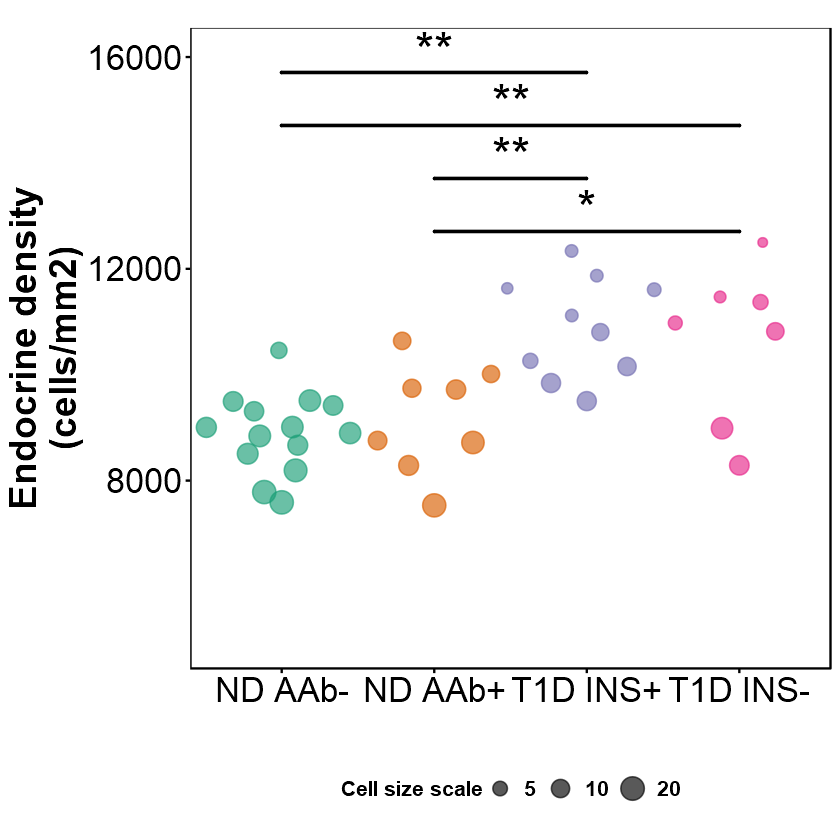

In [132]:
bubble <- import("cell3.csv")

bubble = bubble[!duplicated(bubble$nPODCaseID),]

#Recode and order the variables
bubble %<>% mutate(donor_range = ifelse(donorgroup == "No diabetes", "ND AAb-",
                                       ifelse(donorgroup == "Autoab Pos", "ND AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))

bubble <- within(bubble,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                     "ND AAb+",
                                                        "ND AAb-"))))



p<-ggplot(bubble,aes(x=donor_range, y=mean_endocrine_density, color=donor_range, size=mean_endocrine_cell_size_scale1)) + 
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("No diabetes" = "#1B9E77", "ND AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
geom_quasirandom(inherit.aes=TRUE, alpha=0.65, width=.6) + #width= to increase spread
theme (aspect.ratio=1/1)+
  ylab("Endocrine density\n(cells/mm2)") +
  xlab("") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)    
  theme(legend.position="bottom", legend.text=element_text(size=12, face="bold", family="Arial"), legend.title=element_text(size=12, face="bold", family="Arial"),
        axis.text=element_text(size=20, color="black", family="Arial"), axis.title=element_text(size=22, face="bold", family="Arial", color="black"), axis.ticks=element_line(color="black"),
      panel.background=element_blank(), panel.border = element_rect(color = "black", fill=NA, size=.5, linetype=1)) +
scale_y_continuous(limits=c(5000,16000))+
        geom_signif(comparisons=list(c("ND AAb+", "T1D INS-")),
                      y_position = 12700, annotation=c("*"), tip_length=0, size=.75,  color="black", textsize=10)+
        geom_signif(comparisons=list(c("ND AAb+", "T1D INS+")),
                      y_position = 13700, annotation=c("**"), tip_length=0, size=.75,color="black", textsize=10)+
        geom_signif(comparisons=list(c("ND AAb-", "T1D INS-")),
                      y_position = 14700, annotation=c("**"), tip_length=0, size=.75, color="black", textsize=10)+
        geom_signif(comparisons=list(c("ND AAb-", "T1D INS+")),
                      y_position = 15700, annotation=c("**"), tip_length=0, size=.75, color="black", textsize=10)+
scale_size_continuous(limits=c(0.1,20), breaks=c(5,10,20))



fig4a<-p+labs(size="Cell size scale") + guides(size=guide_legend(nrow=1))  + theme(legend.key=element_blank()) 


fig4a

#save_plot("fig6.tiff", fig6, base_aspect_ratio=5/1)
ggsave("fig4a.png", fig4a,  height = 7, width = 7, units="in", dpi = 500, scale=1)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"

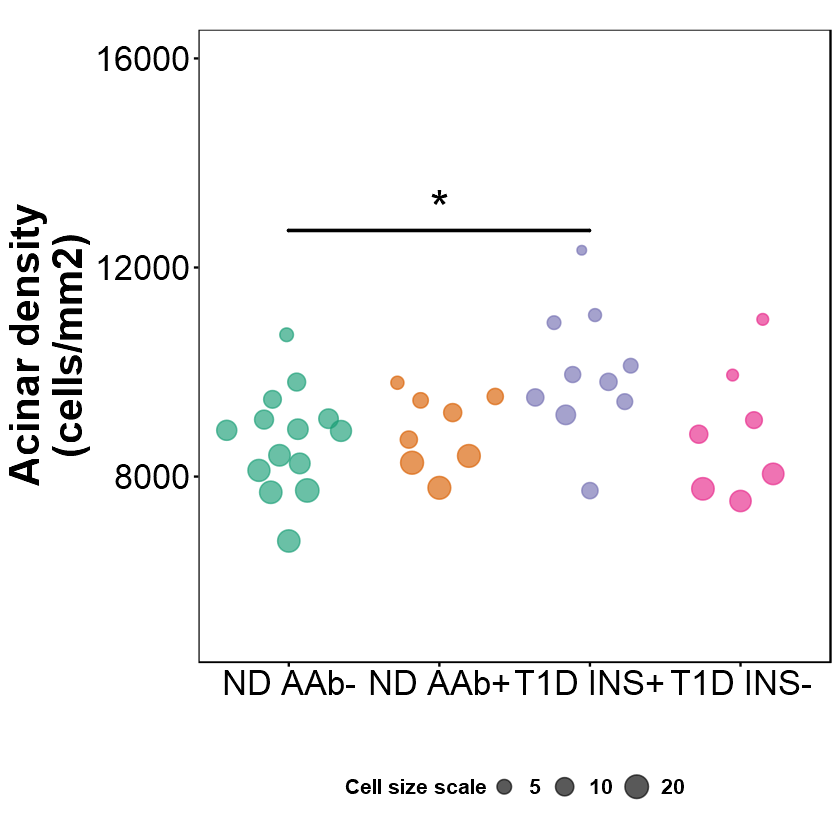

In [133]:
bubble <- import("cell3.csv")
bubble = bubble[!duplicated(bubble$nPODCaseID),]
#Recode and order the variables
bubble %<>% mutate(donor_range = ifelse(donorgroup == "No diabetes", "ND AAb-",
                                       ifelse(donorgroup == "Autoab Pos", "ND AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-"))))

bubble <- within(bubble,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                     "ND AAb+",
                                                        "ND AAb-"))))

p<-ggplot(bubble,aes(x=donor_range, y=mean_acinar_density, color=donor_range, size=mean_acinar_cell_size_scale1)) + 
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#D95F02", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("No diabetes" = "#1B9E77", "ND AAb+" = "#D95F02", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette

#scale_size_continuous(range=c(0.1, 10)) +
geom_quasirandom(inherit.aes=TRUE, alpha=0.65, width=0.5) +
  ylab("Acinar density\n(cells/mm2)") +
  xlab("") +
  # replace none with the following to add the legend back into the figure: c(.785,.90)    
  theme(aspect.ratio=1/1, legend.position="bottom", legend.text=element_text(size=12, face="bold", family="Arial"), legend.title=element_text(size=12, face="bold", family="Arial"),
        axis.text=element_text(size=20, color="black", family="Arial"), axis.title=element_text(size=24, face="bold", family="Arial", color="black"), axis.ticks=element_line(color="black"),
        panel.background=element_blank(), panel.border = element_rect(color = "black", fill=NA, size=.5, linetype=1)) +
scale_y_continuous(limits=c(5000,16000))+
        geom_signif(comparisons=list(c("ND AAb-", "T1D INS+")),
                      y_position = 12700, annotation=c("*"), tip_length=0, size=.75, color="black", textsize=10)+
scale_size_continuous(limits=c(0.1,20), breaks=c(5,10,20))

fig4b<-p+labs(size="Cell size scale") + guides(size=guide_legend(nrow=1)) + theme(legend.key=element_blank())


fig4b

#save_plot("fig3b.tiff", fig3b, base_aspect_ratio=1)
ggsave("fig4b.png", fig4b,  height = 7, width = 7, units="in", dpi = 500)

In [134]:
fig4<-plot_grid(fig4a, fig4b, nrow=1, ncol=2, 
                #labels="A", 
                label_size=30,
               label_x=0,
               label_y=1)





#features like expand=() expand_limits()  expand=expand_scale()
ggsave("fig4.tiff", fig4, dpi = 300, height=15, width=15)
#save_plot("fig3.tiff", fig3, ncol=2, nrow=1, base_aspect_ratio=.9/1)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warnin

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family 'Arial' not found in PostScript font database"
Warnin

In [135]:
%explore(endocrine_density);

In [136]:
PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  endocrine_density =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=hf; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;

In [137]:
%explore('islets: Avg Cell Area (cell size'n);

In [138]:
PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  'islets: Avg Cell Area (cell size'n =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=csh; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;

In [139]:
%explore(acinar_density);

In [140]:
PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  acinar_density =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;

In [141]:
%explore('acinar: Avg Cell Area (cell size'n);

In [142]:
PROC mixed data=cell3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     format region $regionformat.;
     class nPODCaseID donorgroup region;
     model  'acinar: Avg Cell Area (cell size'n =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;

### figure 2

In [143]:
/*for duct study*/
DATA duct_demo_limited (keep=nPODCaseID Donortype);
    set duct_demo;
RUN;

data duct2;
    merge duct1 (in=a) duct_demo_limited;
    by nPODCaseID;
    if a;
RUN;

DATA duct3;
    set duct2;
    duct_thickness_old=('Main Duct Mean Thickness (um)'n)/('Total Tissue Area (mm^2)'n); /*originally considered, but incorrect*/
    duct_thickness_relative=('Main Duct Mean Thickness (um)'n)/('Main Duct Area (mm^2)'n);
    duct_thickness_absolute='Main Duct Mean Thickness (um)'n;
    percent_duct_area=('Main Duct Area (mm^2)'n)/('Total Tissue Area (mm^2)'n)*100;
    duct_area='Main Duct Area (mm^2)'n;
    donorgroup=donortype;
    if INS=0 and donortype="T1D" then donorgroup="Ins. neg. T1D";
    if INS=1 and donortype="T1D" then donorgroup="Ins. pos. T1D";
RUN;



PROC sql;
    create table duct4 as
    select * from duct3
    outer union corr
    select nPODCaseID, DonorType,donorgroup,
    mean(percent_duct_area) as percent_duct_area,
    'O' as region
    from duct3
    group by nPODCaseID, DonorType,donorgroup
    order by nPODCaseID, DonorType, donorgroup, region;
quit;



/*inspect data*/

proc export data=duct3
     outfile="&location\Data\duct3.csv" 
     dbms=csv
     replace;
run; 


proc export data=duct4
     outfile="&location\Data\duct4.csv" 
     dbms=csv
     replace;
run; 


Warning message:
"Duplicated aesthetics after name standardisation: colour"
Warning message:
"Use of `boxplot$donor_range` is discouraged. Use `donor_range` instead."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.g

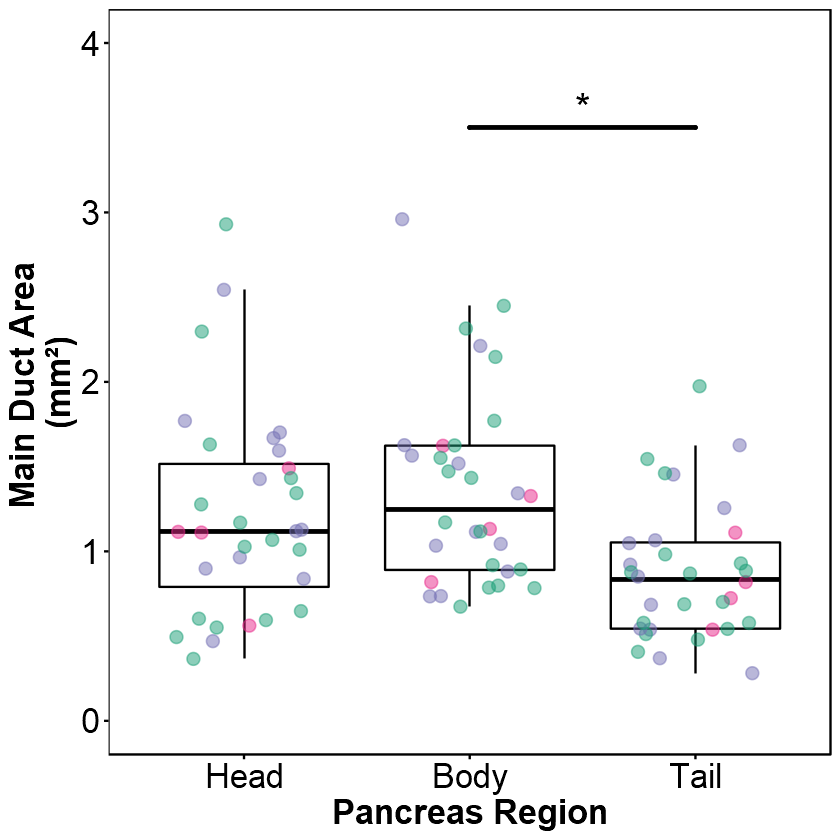

In [144]:
boxplot<-import("duct3.csv")


boxplot %<>% mutate(donor_range = ifelse(donorgroup == "No diabetes", "No diabetes",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D INS+",
                                                    "T1D INS-")))

boxplot <- within(boxplot,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D INS-",
                                                     "T1D INS+",
                                                           "No diabetes"))))


boxplot %<>% mutate(region = ifelse(region == "PH", "Head",
                                             ifelse(region == "PB", "Body",
                                                    "Tail")))

# for reordering the columns
boxplot <- within(boxplot,region <- factor(region,
                                            levels=rev(c("Tail",
                                                     "Body",
                                                     "Head"))))




#boxplots defaults used, i.e. box represents IQR, whiskers 1.5*IQR, beyond whiskers are outliers, and line within box is the median.  
fig8<-ggplot(boxplot, aes(region,duct_area)) +
geom_boxplot(outlier.size=NA, outlier.color=NA, color="black", alpha=0.3, show.legend=FALSE, color=boxplot$donor_range) +
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("No diabetes" = "#1B9E77", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
  

geom_jitter(aes(region,duct_area, color=boxplot$donor_range),
        position=position_jitter(width=0.3,height=0),
        alpha=0.5,
        size=3,
        show.legend=FALSE)+
    xlab("Pancreas Region") +
    ylab("Main Duct Area \n(mm²)") +
    theme(axis.title = element_text(size=20,color='black', family="Arial", face="bold"),
          axis.text = element_text(size=20,color='black', family="Arial"), 
          axis.ticks=element_line(color="black"),
          panel.background=element_blank())+
     panel_border(colour = "black", size = 0.5, linetype = 1, remove = FALSE)+
     geom_signif(y_position=3.5, xmin=2, xmax=3,
     annotation="*", tip_length=0, size=1, textsize=8, color="black") + #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html

scale_y_continuous(limits=c(0,4))

fig8

save_plot("fig1_part2.tiff", fig8, base_aspect_ratio=1/1.05)

Warning message:
"Duplicated aesthetics after name standardisation: colour"
Warning message:
"Use of `my_data$donor_range` is discouraged. Use `donor_range` instead."
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"
Warning message in grid.Call(C_textBounds, as.g

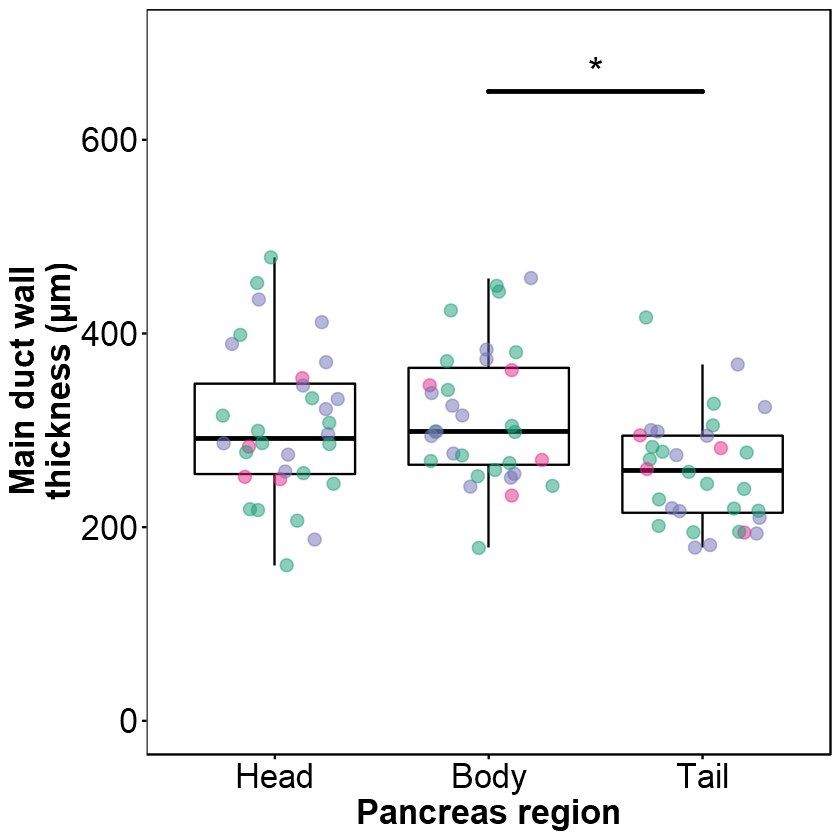

In [145]:
#try alternative version of above figure

my_data<-import("duct3.csv")





#Recode and order the variables
my_data %<>% mutate(donor_range = ifelse(donorgroup == "No diabetes", "No T1D",
                                       ifelse(donorgroup == "Autoab Pos", "AAb+",
                                              ifelse(donorgroup == "Ins. pos. T1D", "T1D I+",
                                                    "T1D I-"))))

my_data <- within(my_data,donor_range <- factor(donor_range,
                                            levels=rev(c("T1D I-",
                                                     "T1D I+",
                                                     "AAb+",
                                                        "No T1D"))))


#Recode and order the variables
my_data %<>% mutate(region = ifelse(region == "PH", "Head",
                                             ifelse(region == "PB", "Body",
                                                    "Tail")))

my_data <- within(my_data,region <- factor(region,
                                            levels=rev(c("Tail",
                                                     "Body",
                                                     "Head"))))



#boxplots defaults used, i.e. box represents IQR, whiskers 1.5*IQR, beyond whiskers are outliers, and line within box is the median.  
fig8<-ggplot(my_data, aes(region,duct_thickness_absolute)) +
geom_boxplot(outlier.size=NA, outlier.color=NA, color="black", alpha=0.3, show.legend=FALSE, color=my_data$donor_range) +
scale_color_manual(guide = FALSE, values =c("#1B9E77", "#7570B3", "#E7298A")) + #comment this line out if you want to use R's auto-color palette
scale_fill_manual(guide = FALSE, values=c("No diabetes" = "#1B9E77", "T1D INS+" = "#7570B3", "T1D INS-" = "#E7298A")) +  #comment this line out if you want to use R's auto-color palette
  

geom_jitter(aes(region,duct_thickness_absolute, color=my_data$donor_range),
        position=position_jitter(width=0.3,height=0),
        alpha=0.5,
        size=3,
        show.legend=FALSE)+
    xlab("Pancreas region") +
    ylab("Main duct wall\nthickness (µm)") +
    theme(axis.title = element_text(size=20,color='black', family="Arial", face="bold"),
          axis.text = element_text(size=20,color='black', family="Arial"), 
          axis.ticks=element_line(color="black"),
          panel.background=element_blank())+
     panel_border(colour = "black", size = 0.5, linetype = 1, remove = FALSE)+
       geom_signif(y_position=c(650), xmin=c(2), xmax=c(3),
              annotation=c("*"), tip_length=0, size=1, color="black", textsize=8, alpha=1)+ #see here https://rdrr.io/cran/ggsignif/man/stat_signif.html
scale_y_continuous(limits=c(0,700))


fig8

save_plot("fig1_part3_version2.tiff", fig8, base_aspect_ratio=1/1.05)

In [146]:
head(my_data)

region INS Main Duct Mean Thickness (um) Main Duct Area (mm^2)
1 Head   1   296.0731                      1.1194240            
2 Body   1   241.8954                      0.7346199            
3 Tail   1   181.5942                      0.3695368            
4 Head   0   249.5125                      0.5618954            
5 Body   0   362.2054                      1.3265906            
6 Tail   0   294.8600                      0.7241359            
  Total Tissue Area (mm^2) thickness/total tissue area
1  40.69554                7.275321                   
2  68.44247                3.534288                   
3  34.11300                5.323312                   
4  79.18452                3.151026                   
5 107.86835                3.357847                   
6 102.34494                2.881041                   
  percentage of duct area out of t nPODCaseID DonorType duct_thickness_old
1 2.7507293                        6052       T1D       7.275321          
2 1.0733393                        6052       T1D       3.534288          
3 1.0832724                        6052       T1D       5.323312          
4 0.7096027                        6062       T1D       3.151026          
5 1.2298237                        6062       T1D       3.357847          
6 0.7075445                        6062       T1D       2.881041          
  duct_thickness_relative duct_thickness_absolute percent_duct_area duct_area
1 264.4870                296.0731                2.7507293         1.1194240
2 329.2796                241.8954                1.0733393         0.7346199
3 491.4103                181.5942                1.0832724         0.3695368
4 444.0550                249.5125                0.7096027         0.5618954
5 273.0348                362.2054                1.2298237         1.3265906
6 407.1887                294.8600                0.7075445         0.7241359
  donorgroup    donor_range
1 Ins. pos. T1D T1D I+     
2 Ins. pos. T1D T1D I+     
3 Ins. pos. T1D T1D I+     
4 Ins. neg. T1D T1D I-     
5 Ins. neg. T1D T1D I-     
6 Ins. neg. T1D T1D I-

statistical analysis for figure 2

In [147]:
/*
Covariance structures considered include:
homogeneous covariance structures
vc - simplist, correlation of errors assumed to be 0
cs - compound symmetry, constant variance and covariance

heterogeneous covariance structure
un - unstructured, most complex
unr- unstructured correlation
un(1) - banded main diagonal
csh - heterogeneous compound symmetry
hf - Huynh-Feldt (similar to csh) 
arh(1) - autoregressive heterogeneous
*/


%macro explore (a);

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=vc; 
     ods output FitStatistics=Fitvc(rename=(value=vc)) Dimensions=Parmvc(rename=(value=Numvc)) ConvergenceStatus=ConvergeStatusvc; 
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusvc;
    set ConvergeStatusvc;
    covar="vc ";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=cs; 
     ods output FitStatistics=Fitcs(rename=(value=cs)) Dimensions=Parmcs(rename=(value=Numcs)) ConvergenceStatus=ConvergeStatuscs;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatuscs;
    set ConvergeStatuscs;
    covar="cs ";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution;/*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=un; 
     ods output FitStatistics=Fitun(rename=(value=un)) Dimensions=Parmun(rename=(value=Numun)) ConvergenceStatus=ConvergeStatusun;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusun;
    set ConvergeStatusun;
    covar="un ";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)   type=unr; 
     ods output FitStatistics=Fitunr(rename=(value=unr)) Dimensions=Parmunr(rename=(value=Numunr)) ConvergenceStatus=ConvergeStatusunr;  
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusunr;
    set ConvergeStatusunr;
    covar="unr";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un(1); 
     ods output FitStatistics=Fitun1(rename=(value=un1)) Dimensions=Parmun1(rename=(value=Numun1)) ConvergenceStatus=ConvergeStatusun1;  
     parms/ols;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusun1;
    set ConvergeStatusun1;
    covar="un1";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=csh; 
     ods output FitStatistics=Fitcsh(rename=(value=csh)) Dimensions=Parmcsh(rename=(value=Numcsh)) ConvergenceStatus=ConvergeStatuscsh; 
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatuscsh;
    set ConvergeStatuscsh;
    covar="csh";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=hf; 
     ods output FitStatistics=Fithf(rename=(value=hf)) Dimensions=Parmhf(rename=(value=Numhf)) ConvergenceStatus=ConvergeStatushf;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatushf;
    set ConvergeStatushf;
    covar="hf ";
RUN;

PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  &a= region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=arh(1); 
     ods output FitStatistics=Fitarh1(rename=(value=arh1)) Dimensions=Parmarh1(rename=(value=Numarh1)) ConvergenceStatus=ConvergeStatusarh1;
     /*lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;*/
run;
DATA ConvergeStatusarh1;
    set ConvergeStatusarh1;
    covar="arh(1) ";
RUN;

DATA all;
    merge work.fit:;
RUN;

/*above merge line merges all files with the prefix fit.  The reason for this instead of spelling out each file is because 
some fitstatistics files do not exist for each covar structure tested*/

PROC print data=all label noobs;
RUN;

DATA STATUS;
    set ConvergeStatus:;
RUN;

proc print data=status; run;

%mend explore;



In [148]:
%explore(duct_thickness_absolute);

In [149]:
PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  duct_thickness_absolute =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;

In [150]:
%explore(percent_duct_area);

In [151]:
PROC mixed data=duct3 /*maxiter=1000 maxfunc=5000  can also use covtest*/;
     class nPODCaseID donorgroup region;
     model  duct_area =region|donorgroup/solution; /*can use  ddfm = kenwardroger after solution for unbalanced data to improve performance of t and f tests*/
     /*option e3 after solution helps to describe how type 3 tests were constructed*/
     repeated  region/ subject=nPODCaseID(donorgroup)  type=un; 
     lsmeans region|donorgroup/adjust=tukey cl pdiff alpha=0.05;
run;